## Import

In [1]:
!$PIP_INSTALL pyflann-py3 torchviz torchsummary

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 9.1 MB/s eta 0:00:0000:0100:01m
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for pyflann-py3: filename=pyflann_py3-0.1.0-py3-none-any.whl size=7186987 sha256=7e4472ae8307b3ad7944d4330d7f0be487d4e9eb464ce9c4c05c3596fad69d3a
  Stored in directory: /tmp/pip-ephem-wheel-cache-353ygkcx/wheels/9a/5e/9b/fc41594638a968f62ed4bbec0bbc538288a9b265c4e4dcc67f
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=6b13d6c6b6458d7b4fe0bbfaee804c1f302be9d584b1a9a46602a4495506cc23
  Stored in directory: /tmp/pip-ephem-wheel-cache-353ygkcx/wheels/9b/24/ba/3b068d2fe44524b70c946ce02316cede30a60bd8b93de388e7
Successfully built pyflann-py3 torchviz
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
%reload_ext watermark
%reload_ext autoreload
%autoreload 2
%watermark -p pytransform3d,matplotlib,scipy,numpy,pyflann
# %watermark -p numpy,sklearn,pandas
# %watermark -p ipywidgets,cv2,PIL,matplotlib,plotly,netron
# %watermark -p torch,torchvision,torchaudio
# %watermark -p tensorflow,tensorboard,tflite
# %watermark -p onnx,tf2onnx,onnxruntime,tensorrt,tvm
# %matplotlib inline
# %config InlineBackend.figure_format='retina'
# %config IPCompleter.use_jedi = False

%matplotlib inline
# %matplotlib widget
# from IPython.display import display, Markdown, HTML, IFrame, Image, Javascript
# from IPython.core.magic import register_line_cell_magic, register_line_magic, register_cell_magic
# display(HTML('<style>.container { width:%d%% !important; }</style>' % 90))

import sys, os, io, logging, time, random, math
import json, base64, requests, shutil
import argparse, shlex, signal
import numpy as np
import scipy.io as sio
import torch

np.set_printoptions(
    edgeitems=3, infstr='inf',
    linewidth=75, nanstr='nan', precision=6,
    suppress=True, threshold=100, formatter=None)

argparse.ArgumentParser.exit = lambda *arg, **kwargs: _IGNORE_

def _IMPORT(x, tag='main', debug=False):
    def __request_text(url):
        response = requests.get(url)
        if response.status_code == 200:
            return response.text
        else:
            raise RuntimeError(url)
    try:
        x = x.strip()
        if x[0] == '/' or x[1] == '/':
            with open(x) as fr:
                x = fr.read()
        elif 'github' in x or 'gitee' in x:
            if x.startswith('import '):
                x = x[7:]
            if x.startswith('https://'):
                x = x[8:]
            if not x.endswith('.py'):
                x = x + '.py'
            x = x.replace('blob/main/', '').replace('blob/master/', '')
            if x.startswith('raw.githubusercontent.com'):
                x = 'https://' + x
                x = __request_text(x)
            elif x.startswith('github.com'):
                x = x.replace('github.com', 'raw.githubusercontent.com')
                mod = x.split('/')
                x = 'https://' + '/'.join(mod[:3]) + f'/{tag}/' + '/'.join(mod[-3:])
                x = __request_text(x)
            elif x.startswith('gitee.com'):
                mod = x.split('/')
                x = 'https://' + '/'.join(mod[:3]) + f'/raw/{tag}/' + '/'.join(mod[3:])
                x = __request_text(x)
        if debug:
            return x
        else:
            exec(x, globals())
    except Exception as err:
        # sys.stderr.write(f'request {x} : {err}')
       pass

def _DIR(x, dumps=True, ret=True):
    attrs = sorted([y for y in dir(x) if not y.startswith('_')])
    result = '%s: %s' % (str(type(x))[8:-2], json.dumps(attrs) if dumps else attrs)
    if ret:
        return result
    print(result)


###
### Display ###
###

_IMPORT('import pandas as pd')
_IMPORT('import cv2')
_IMPORT('from PIL import Image')
_IMPORT('import matplotlib.pyplot as plt')
# _IMPORT('import plotly')
# _IMPORT('import plotly.graph_objects as go')
# _IMPORT('import ipywidgets as widgets')
# _IMPORT('from ipywidgets import interact, interactive, fixed, interact_manual')
_IMPORT('import pytransform3d.rotations')
_IMPORT('import pytransform3d.camera')
_IMPORT('import pytransform3d.transformations')
_IMPORT('import pyflann')
# plotly.offline.init_notebook_mode(connected=False)

plt.rcParams['figure.figsize'] = (12.0, 8.0)
# from matplotlib.font_manager import FontProperties
# simsun = FontProperties(fname='/sysfonts/simsun.ttc', size=12)

    
def show_image(imgsrc, width=None, height=None, rgb=True):
    if isinstance(imgsrc, np.ndarray):
        plt.close('all')
        img = imgsrc
        if width or height:
            if width and height:
                size = (width, height)
            else:
                rate = img.shape[1] / img.shape[0]
                if width:
                    size = (width, int(width/rate))
                else:
                    size = (int(height*rate), height)
            img = cv2.resize(img, size)
            plt.figure(figsize=(3*int(size[0]/80+1), 3*int(size[1]/80+1)), dpi=80)
        plt.axis('off')
        if len(img.shape) > 2:
            if not rgb:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img);
        else:
            plt.imshow(img, cmap='gray');
        return

    W, H = '', ''
    if width:
        W = 'width=%d' % width
    if height:
        H = 'height=%d' % height
    if imgsrc.startswith('http'):
        data_url = imgsrc
    else:
        if len(imgsrc) > 2048:
            data_url = 'data:image/jpg;base64,' + imgsrc
        else:
            img = open(imgsrc, 'rb').read()
            data_url = 'data:image/jpg;base64,' + base64.b64encode(img).decode()
    return HTML('<center><img %s %s src="%s"/></center>' % (W, H, data_url))

pytransform3d: 3.5.0
matplotlib   : 3.5.1
scipy        : 1.8.0
numpy        : 1.22.3
pyflann      : 1.6.14



In [3]:
from collections import namedtuple
from dataclasses import dataclass

## Global

In [4]:
TOP_DIR='/jupyter/hzcsbet/gamebet'
CKPTS_DIR = f'{TOP_DIR}/checkpoints'
HEIGHT, WIDTH = 720, 1280
template_h, template_w = 74, 115
interpolation = cv2.INTER_AREA # 缩小适用

class COLORS(object):
    # BGR
    GREEN      = (0   , 255 , 0)
    RED        = (0   , 0   , 255)
    BLACK      = (0   , 0   , 0)
    YELLOW     = (0   , 255 , 255)
    WHITE      = (255 , 255 , 255)
    CYAN       = (255 , 255 , 0)
    MAGENTA    = (255 , 0   , 242)
    GOLDEN     = (32  , 218 , 165)
    LIGHT_BLUE = (255 , 9   , 2)
    PURPLE     = (128 , 0   , 128)
    CHOCOLATE  = (30  , 105 , 210)
    PINK       = (147 , 20  , 255)
    ORANGE     = (0   , 69  , 255)

sys.path.append(f'{TOP_DIR}/python')
    
if not os.path.isdir(CKPTS_DIR):
    os.mkdir(CKPTS_DIR)

In [5]:
def _print_dictkeys_shape(d):
    for k, v in d.items():
        if k.startswith('__'):
            continue
        print(f'{k}: {v.shape}')
        
def _print_statistics(o, prefix=''):
    if isinstance(o, np.ndarray):
        print(f'{prefix} mean: {o.mean()}, std: {o.std()}, max: {o.max()}, min:{o.min()}')
    
def _print_matrix(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")
_print_star = lambda n = 50: print('*' * n)

In [6]:
def _imshow(image, color='rgb', figsize=(6, 3)):
    plt.close('all')
    plt.figure(figsize=figsize)
    plt.axis('off')
    if color == 'gray':
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

## Dataset

### worldcup2014.mat

In [7]:
worldcup_2014_mat = sio.loadmat(f'{TOP_DIR}/data/worldcup2014.mat')
_print_dictkeys_shape(worldcup_2014_mat)

points: (302, 2)
line_segment_index: (151, 2)
grid_points: (2204, 2)


In [8]:
points = worldcup_2014_mat['points']
_print_statistics(points[:, 0], 'points'), _print_statistics(points[:, 1], 'points');

points mean: 52.50027599999999, std: 27.479935120360008, max: 105.000552, min:0.0
points mean: 34.001964, std: 11.397408419732242, max: 68.003928, min:0.0


    UofT:
        template_h: 74 * 0.9144 = 67.6656
        template_w: 115 * 0.9144 = 105.156

In [9]:
points[100:110]

array([[105.000552,  13.885164],
       [ 88.541352,  13.885164],
       [105.000552,  54.118764],
       [ 88.541352,  54.118764],
       [ 99.514152,  24.857964],
       [ 99.514152,  43.145964],
       [105.000552,  24.857964],
       [ 99.514152,  24.857964],
       [105.000552,  43.145964],
       [ 99.514152,  43.145964]])

In [10]:
worldcup_2014_mat['line_segment_index'][:10]

array([[ 0,  1],
       [ 2,  3],
       [ 4,  5],
       [ 6,  7],
       [ 8,  9],
       [10, 11],
       [12, 13],
       [14, 15],
       [16, 17],
       [18, 19]], dtype=uint16)

(69, 106, 3)

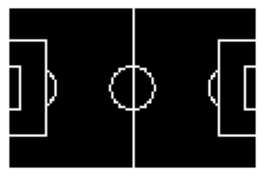

In [11]:
w, h = int(np.ceil(points[:, 0].max())), int(np.ceil(points[:, 1].max()))
img_soccer_field = np.zeros((h, w, 3), dtype=np.uint8)
for idx1, idx2 in worldcup_2014_mat['line_segment_index']:
    p1, p2 = points[idx1], points[idx2]
    q1 = np.rint(p1).astype(np.int32)
    q2 = np.rint(p2).astype(np.int32)
    cv2.line(img_soccer_field, tuple(q1), tuple(q2), COLORS.WHITE)
    
_imshow(img_soccer_field)
img_soccer_field.shape

### worldcup_dataset_camera_parameter.mat

In [12]:
worldcup_camera_parameter = sio.loadmat(f'{TOP_DIR}/data/worldcup_dataset_camera_parameter.mat')
_print_dictkeys_shape(worldcup_camera_parameter)

cc_max: (1, 3)
cc_mean: (1, 3)
cc_min: (1, 3)
cc_std: (1, 3)
fl_max: (1, 1)
fl_mean: (1, 1)
fl_min: (1, 1)
fl_std: (1, 1)


In [13]:
worldcup_camera_parameter

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Mon Jan 29 09:43:18 2018',
 '__version__': '1.0',
 '__globals__': [],
 'cc_max': array([[ 60.845633, -16.741782,  23.011261]]),
 'cc_mean': array([[ 52.366185, -45.156501,  16.821567]]),
 'cc_min': array([[ 45.056791, -66.070204,  10.138713]]),
 'cc_std': array([[2.231926, 9.382564, 2.948753]]),
 'fl_max': array([[5696.984549]]),
 'fl_mean': array([[3018.181398]]),
 'fl_min': array([[1463.164684]]),
 'fl_std': array([[716.068171]])}

### worldcup_sampled_cameras.mat

In [14]:
worldcup_sampled_cameras = sio.loadmat(f'{TOP_DIR}/data/worldcup_sampled_cameras.mat')
_print_dictkeys_shape(worldcup_sampled_cameras)

pivot_cameras: (91173, 9)
positive_cameras: (91173, 9)
positive_ious: (91173, 1)


In [15]:
worldcup_sampled_cameras['pivot_cameras'][12:18]

array([[ 640.      ,  360.      , 3854.144927,    1.6884  ,    0.243943,
          -0.213464,   51.974747,  -53.391455,   15.158311],
       [ 640.      ,  360.      , 4992.664677,    1.724868,   -0.236567,
           0.192668,   58.227037,  -43.640134,   13.287872],
       [ 640.      ,  360.      , 2918.389825,    1.736694,    0.138454,
          -0.111589,   48.270506,  -47.907207,   14.251457],
       [ 640.      ,  360.      , 3604.84738 ,    1.772747,   -0.022877,
           0.008633,   53.119063,  -41.81307 ,   14.684627],
       [ 640.      ,  360.      , 2797.713665,    1.656788,   -0.239269,
           0.21015 ,   52.201609,  -43.969138,   13.911572],
       [ 640.      ,  360.      , 4022.714545,    1.738111,   -0.151789,
           0.134468,   53.14781 ,  -47.103762,   12.389078]])

In [16]:
worldcup_sampled_cameras['positive_ious'][12:18]

array([[0.920784],
       [0.924863],
       [0.955476],
       [0.920055],
       [0.958889],
       [0.985767]])

### features/database_camera_feature.mat

In [17]:
database_camera_features = sio.loadmat(f'{TOP_DIR}/data/features/database_camera_feature.mat')
_print_dictkeys_shape(database_camera_features)

cameras: (91173, 9)
features: (91173, 16)


In [18]:
database_camera_features['cameras'][:5]

array([[ 640.      ,  360.      , 1843.086214,    1.668861,    0.237341,
          -0.216936,   51.725313,  -55.24253 ,   13.741604],
       [ 640.      ,  360.      , 2735.760138,    1.683446,   -0.439934,
           0.380944,   55.36815 ,  -47.510307,   15.00194 ],
       [ 640.      ,  360.      , 2636.988208,    1.710394,    0.35452 ,
          -0.30104 ,   50.968008,  -56.355524,   13.276288],
       [ 640.      ,  360.      , 1969.785521,    1.639676,    0.421219,
          -0.381463,   49.688613,  -27.465165,   17.864562],
       [ 640.      ,  360.      , 2702.236468,    1.786187,   -0.126308,
           0.106665,   49.974861,  -54.884818,   16.401735]])

In [19]:
# calculate from siamese neural network
database_camera_features['features'][:5]

array([[-0.372055, -0.09087 , -0.259755, -0.208958,  0.21655 , -0.135903,
         0.207431,  0.185724, -0.221791,  0.125692,  0.043995,  0.469147,
        -0.093933,  0.227581,  0.495774,  0.076366],
       [ 0.267115,  0.11651 , -0.386815, -0.154943, -0.17079 , -0.271643,
         0.10116 , -0.144005,  0.252797,  0.299399,  0.400056, -0.09353 ,
         0.089256,  0.375996,  0.236919,  0.282277],
       [ 0.646169, -0.152043, -0.403935, -0.07253 , -0.016389, -0.004778,
        -0.090194, -0.087009,  0.240885,  0.287335,  0.152687,  0.284175,
        -0.30157 , -0.012018, -0.123235, -0.154816],
       [-0.115721, -0.269547,  0.277795, -0.260665, -0.022519,  0.030737,
        -0.107026, -0.235174,  0.190954,  0.126271, -0.248658, -0.424408,
         0.493188,  0.300325,  0.230555,  0.140185],
       [ 0.297994,  0.317869,  0.033043, -0.257077, -0.295638, -0.128306,
         0.220009, -0.255847,  0.546875, -0.143696,  0.195117,  0.130659,
         0.278087, -0.027115,  0.259274, -0.0712

### features/testset_feature.mat

In [20]:
testset_features = sio.loadmat(f'{TOP_DIR}/data/features/testset_feature.mat')
_print_dictkeys_shape(testset_features)

edge_distances: (180, 320, 1, 186)
edge_map: (720, 1280, 1, 186)
features: (16, 186)


In [21]:
# calculate by cv.distanceTransform
show_num = 4
edge_distances_x = testset_features["edge_distances"][..., :show_num]
edge_distances_x.shape

(180, 320, 1, 4)

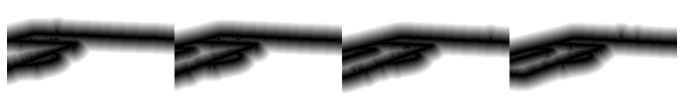

In [22]:
_imshow(np.hstack(np.split(edge_distances_x, indices_or_sections=show_num, axis=-1)).squeeze(), color='gray', figsize=(3 * show_num, 2))

In [23]:
show_num = 4
edge_map_x = testset_features["edge_map"][..., :show_num]
edge_map_x.shape

(720, 1280, 1, 4)

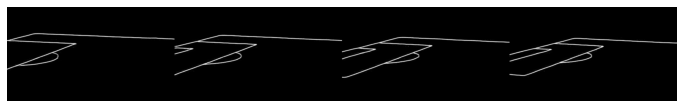

In [24]:
_imshow(np.hstack(np.split(edge_map_x, indices_or_sections=show_num, axis=-1)).squeeze(), color='gray', figsize=(3 * show_num, 2))

### UoT_soccer/train_val.mat

In [25]:
train_val_UoT = sio.loadmat(f'{TOP_DIR}/data/UoT_soccer/train_val.mat')
_print_dictkeys_shape(train_val_UoT)

annotation: (1, 209)
meta: (1, 1)


In [26]:
train_val_UoT['meta']

array([[(array(['train_val'], dtype='<U9'), array(['/Users/jimmy/Desktop/images/UoT_soccer/train_val'], dtype='<U48'))]],
      dtype=[('data_type', 'O'), ('folder', 'O')])

In [27]:
type(train_val_UoT['annotation'][0][0]), train_val_UoT['annotation'][0][0]

(numpy.void,
 (array(['1.jpg'], dtype='<U5'), array([[ -1.21252 ,   0.032872,  64.237605],
        [ -0.004756,   0.009247, -19.363899],
        [ -0.000126,   0.000496,  -0.053625]])))

In [28]:
train_val_UoT['annotation'][0][15:17]

array([(array(['16.jpg'], dtype='<U6'), array([[   9.964002,    1.539575, -775.332768],
              [  -0.422633,    0.694584,  152.285376],
              [   0.000789,   -0.003297,    0.401312]]))                               ,
       (array(['17.jpg'], dtype='<U6'), array([[   8.145961,    1.639647, -688.687658],
              [  -0.217398,    0.451414,  126.647341],
              [   0.001019,   -0.002626,    0.2949  ]]))                               ],
      dtype=[('image_name', 'O'), ('homography', 'O')])

In [29]:
h16_gt_mat = sio.loadmat(f'{TOP_DIR}/data/UoT_soccer/16_grass_gt.mat')
_print_dictkeys_shape(h16_gt_mat)

grass: (720, 1280)


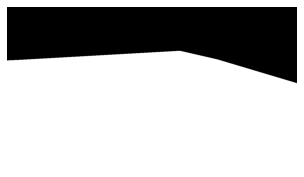

In [30]:
_imshow(h16_gt_mat['grass'], 'gray')

### UoT_soccer/test.mat (same size with testset_feature.mat)

In [31]:
test_UoT = sio.loadmat(f'{TOP_DIR}/data/UoT_soccer/test.mat')
_print_dictkeys_shape(test_UoT)

annotation: (1, 186)
meta: (1, 1)


In [32]:
test_UoT['annotation'][0][14:17]

array([(array(['15.jpg'], dtype='<U6'), array([[ -2.007112,  -0.85111 , 216.439981],
              [ -0.069865,  -0.000754, -25.216801],
              [ -0.000722,   0.000675,  -0.034968]]))                               ,
       (array(['16.jpg'], dtype='<U6'), array([[ 11.11628 ,  -6.766282, 188.062353],
              [  0.440481,   0.381525, 127.388439],
              [ -0.000302,  -0.003024,   0.402609]]))                               ,
       (array(['17.jpg'], dtype='<U6'), array([[   1.878536,   -0.059891, -100.151941],
              [  -0.030807,    0.022421,   28.215382],
              [   0.000111,   -0.000737,    0.08457 ]]))                               ],
      dtype=[('image_name', 'O'), ('homography', 'O')])

In [33]:
!cat $TOP_DIR/data/UoT_soccer/16.homographyMatrix

   1.0313303e-01   2.5604424e-01   1.0209169e+02
   3.8278703e-02   6.0896023e-01  -1.5712712e+02
   1.1163029e-04   4.4997005e-03   1.0000000e+00


## Utils (Not Good,Removed)


$$
(A @ B)^T = B^T @ A^T
$$

### RotationUtil

In [34]:
class RotationUtil:
    @staticmethod
    def rotate_x_axis(angle, T=True):
        """
        rotate coordinate with X axis
        https://en.wikipedia.org/wiki/Rotation_matrix + transpose
        http://mathworld.wolfram.com/RotationMatrix.html
        :param angle: in degree
        :return:
        """
        angle = math.radians(angle)
        s = math.sin(angle)
        c = math.cos(angle)

        r = np.asarray([[1, 0, 0],
                        [0, c, -s],
                        [0, s, c]])
        if T:
            r = np.transpose(r)
        return r

    @staticmethod
    def rotate_y_axis(angle, T=True):
        """
        rotate coordinate with X axis
        :param angle:
        :return:
        """
        angle = math.radians(angle)
        s = math.sin(angle)
        c = math.cos(angle)

        r = np.asarray([[c, 0, s],
                        [0, 1, 0],
                        [-s, 0, c]])
        if T:
            r = np.transpose(r)
        return r

    @staticmethod
    def rotate_z_axis(angle, T=True):
        """

        :param angle:
        :return:
        """
        angle = math.radians(angle)
        s = math.sin(angle)
        c = math.cos(angle)

        r = np.asarray([[c, -s, 0],
                        [s, c, 0],
                        [0, 0, 1]])
        if T:
            r = np.transpose(r)
        return r

    @staticmethod
    def pan_y_tilt_x(pan, tilt):
        """
        Rotation matrix of first pan, then tilt
        :param pan:
        :param tilt:
        :return:
        """
        r_tilt = RotationUtil.rotate_x_axis(tilt)
        r_pan = RotationUtil.rotate_y_axis(pan)
        m = r_tilt @ r_pan
        return m

    #  rot_vec, _ = cv.Rodrigues(rotation)
    @staticmethod
    def rotation_matrix_to_Rodrigues(m):
        assert m.shape[0] == 3 and m.shape[1] == 3
        rot_vec, _ = cv2.Rodrigues(m)
        return rot_vec

In [35]:
degreex, degreey, degreez = 40, 70, -35
anglex, angley, anglez = math.radians(degreex), math.radians(degreey), math.radians(degreez)
anglex, angley, anglez

(0.6981317007977318, 1.2217304763960306, -0.6108652381980153)

In [36]:
rx = RotationUtil.rotate_x_axis(degreex, T=False)
ry = RotationUtil.rotate_y_axis(degreey, T=False)
rz = RotationUtil.rotate_z_axis(degreez, T=False)
rx, ry, rz

(array([[ 1.      ,  0.      ,  0.      ],
        [ 0.      ,  0.766044, -0.642788],
        [ 0.      ,  0.642788,  0.766044]]),
 array([[ 0.34202 ,  0.      ,  0.939693],
        [ 0.      ,  1.      ,  0.      ],
        [-0.939693,  0.      ,  0.34202 ]]),
 array([[ 0.819152,  0.573576,  0.      ],
        [-0.573576,  0.819152,  0.      ],
        [ 0.      ,  0.      ,  1.      ]]))

In [37]:
rx_ = cv2.Rodrigues(np.array([anglex, 0, 0]))[0]
ry_ = cv2.Rodrigues(np.array([0, angley, 0]))[0]
rz_ = cv2.Rodrigues(np.array([0, 0, anglez]))[0]
rx_, ry_, rz_

(array([[ 1.      ,  0.      ,  0.      ],
        [ 0.      ,  0.766044, -0.642788],
        [ 0.      ,  0.642788,  0.766044]]),
 array([[ 0.34202 ,  0.      ,  0.939693],
        [ 0.      ,  1.      ,  0.      ],
        [-0.939693,  0.      ,  0.34202 ]]),
 array([[ 0.819152,  0.573576,  0.      ],
        [-0.573576,  0.819152,  0.      ],
        [ 0.      ,  0.      ,  1.      ]]))

#### 旋转向量与XYZ角度不是同一概念

[绕着旋转向量旋转一定的角度, 可以从一个位置变换到另一个位置](https://euclideanspace.com/maths/geometry/rotations/axisAngle/index.htm)

In [38]:
rxyz = cv2.Rodrigues(np.array([anglex, angley, anglez]))[0]
rxyz

array([[ 0.236285,  0.747074,  0.62133 ],
       [-0.04882 ,  0.647756, -0.760282],
       [-0.970457,  0.14931 ,  0.189527]])

In [39]:
rx @ ry @ rz, rz @ ry @ rx

(array([[ 0.280166,  0.196175,  0.939693],
        [ 0.055401,  0.97396 , -0.219846],
        [-0.958351,  0.113654,  0.262003]]),
 array([[ 0.280166,  0.934172,  0.220976],
        [-0.196175,  0.281054, -0.939428],
        [-0.939693,  0.219846,  0.262003]]))

### ProjectiveCamera

In [40]:
class ProjectiveCamera:
    def __init__(self, fl, u, v, cc, rod_rot):
        """
        :param fl:
        :param u:
        :param v:
        :param cc:
        :param rod_rot:
        """
        self.K = np.zeros((3, 3)) # calibration matrix
        self.camera_center = np.zeros(3)
        self.rotation = np.zeros(3)

        self.P = np.zeros((3, 4)) # projection matrix

        self.set_calibration(fl, u, v)
        self.set_camera_center(cc)
        self.set_rotation(rod_rot)

    def set_calibration(self, fl, u, v):
        """
        :param fl:
        :param u:
        :param v:
        :return:
        """
        self.K = np.asarray([[fl, 0, u],
                             [0, fl, v],
                             [0, 0, 1]])
        self._recompute_matrix()

    def set_camera_center(self, cc):
        assert cc.shape[0] == 3

        self.camera_center[0] = cc[0]
        self.camera_center[1] = cc[1]
        self.camera_center[2] = cc[2]
        self._recompute_matrix()

    def set_rotation(self, rod_rot):
        """
        :param rod_rot: Rodrigues vector
        :return:
        """
        assert rod_rot.shape[0] == 3

        self.rotation[0] = rod_rot[0]
        self.rotation[1] = rod_rot[1]
        self.rotation[2] = rod_rot[2]
        self._recompute_matrix()

    def project_3d(self, x, y, z, w=1.0):
        """
        :param x:
        :param y:
        :param z:
        :return:
        """
        p = np.zeros(4)
        p[0],p[1],p[2], p[3] = x, y, z, w
        q = self.P @ p
        assert q[2] != 0.0
        return (q[0]/q[2], q[1]/q[2])

    def get_homography(self):
        """
        homography matrix from the projection matrix
        :return:
        """
        h = self.P[:, [0, 1,3]]
        return h


    def _recompute_matrix(self):
        """
        :return:
        """
        P = np.zeros((3, 4))
        for i in range(3):
            P[i][i] = 1.0

        for i in range(3):
            P[i][3] = -self.camera_center[i]

        r, _ = cv2.Rodrigues(self.rotation)
        #print(r)
        #print('{} {} {}'.format(self.K.shape, r.shape, P.shape))
        self.P = self.K @ r @ P

### SyntheticUtil

In [41]:
class SyntheticUtil:
    @staticmethod
    def camera_to_edge_image(camera_data,
                             model_points, model_line_segment,
                             im_h=720, im_w=1280, line_width=4):
        """
         Project (line) model images using the camera
        :param camera_data: 9 numbers
        :param model_points:
        :param model_line_segment:
        :param im_h: 720
        :param im_w: 1280
        :return: H * W * 3 Opencv image
        """
        assert camera_data.shape[0] == 9

        u, v, fl = camera_data[0:3]
        rod_rot = camera_data[3:6]
        cc = camera_data[6:9]

        camera = ProjectiveCamera(fl, u, v, cc, rod_rot)
        im = np.zeros((im_h, im_w, 3), dtype=np.uint8)
        n = model_line_segment.shape[0]
        color = (255, 255, 255)
        for i in range(n):
            idx1, idx2 = model_line_segment[i][0], model_line_segment[i][1]
            p1, p2 = model_points[idx1], model_points[idx2]
            q1 = camera.project_3d(p1[0], p1[1], 0.0, 1.0)
            q2 = camera.project_3d(p2[0], p2[1], 0.0, 1.0)
            q1 = np.rint(q1).astype(np.int32)
            q2 = np.rint(q2).astype(np.int32)
            cv2.line(im, tuple(q1), tuple(q2), color, thickness=line_width)
        return im

    @staticmethod
    def distance_transform(img):
        """
        :param img: Opencv Image
        :return:
        """
        h, w, c = img.shape
        if c == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            assert c == 1

        _, binary_im = cv2.threshold(img, 10, 255, cv2.THRESH_BINARY_INV)

        dist_im = cv2.distanceTransform(
            binary_im, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
        return dist_im

    @staticmethod
    def find_transform(im_src, im_dst):
        warp = np.eye(3, dtype=np.float32)
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 50, 0.001)
        # suggested by felibol
        # https://github.com/lood339/SCcv2SD/issues/8
        try:
            _, warp = cv2.findTransformECC(
                im_src, im_dst, warp, cv2.MOTION_HOMOGRAPHY, criteria, None, 5)
        except:
            print('Warning: find transform failed. Set warp as identity')
        return warp

    @staticmethod
    def generate_ptz_cameras(cc_statistics,
                             fl_statistics,
                             roll_statistics,
                             pan_range, tilt_range,
                             u, v,
                             camera_num):
        """
        Input: PTZ camera base information
        Output: randomly sampled camera parameters
        :param cc_statistics:
        :param fl_statistics:
        :param roll_statistics:
        :param pan_range:
        :param tilt_range:
        :param u:
        :param v:
        :param camera_num:
        :return: N * 9 cameras
        """
        cc_mean, cc_std, cc_min, cc_max = cc_statistics
        fl_mean, fl_std, fl_min, fl_max = fl_statistics
        roll_mean, roll_std, roll_min, roll_max = roll_statistics
        pan_min, pan_max = pan_range
        tilt_min, tilt_max = tilt_range

        # generate random values from the distribution
        camera_centers = np.random.normal(cc_mean, cc_std, (camera_num, 3))
        focal_lengths = np.random.normal(fl_mean, fl_std, (camera_num, 1))
        rolls = np.random.normal(roll_mean, roll_std, (camera_num, 1))
        pans = np.random.uniform(pan_min, pan_max, camera_num)
        tilts = np.random.uniform(tilt_min, tilt_max, camera_num)

        cameras = np.zeros((camera_num, 9))
        for i in range(camera_num):
            base_rotation = RotationUtil.rotate_y_axis(0) @ RotationUtil.rotate_z_axis(rolls[i]) @\
                RotationUtil.rotate_x_axis(-90)
            pan_tilt_rotation = RotationUtil.pan_y_tilt_x(pans[i], tilts[i])
            rotation = pan_tilt_rotation @ base_rotation
            rot_vec, _ = cv2.Rodrigues(rotation)

            cameras[i][0], cameras[i][1] = u, v
            cameras[i][2] = focal_lengths[i]
            cameras[i][3], cameras[i][4], cameras[i][5] = rot_vec[0], rot_vec[1], rot_vec[2]
            cameras[i][6], cameras[i][7], cameras[i][8] = camera_centers[i][0], camera_centers[i][1], camera_centers[i][2]
        return cameras

    @staticmethod
    def sample_positive_pair(pp, cc, base_roll, pan, tilt, fl,
                             pan_std, tilt_std, fl_std):
        """
        Sample a camera that has similar pan-tilt-zoom with (pan, tilt, fl).
        The pair of the camera will be used a positive-pair in the training
        :param pp: [u, v]
        :param cc: camera center
        :param base_roll: camera base, roll angle
        :param pan:
        :param tilt:
        :param fl:
        :param pan_std:
        :param tilt_std:
        :param fl_std:
        :return:
        """

        def get_nearby_data(d, std):
            assert std > 0
            delta = np.random.uniform(-0.5, 0.5, 1) * std
            return d + delta

        pan = get_nearby_data(pan, pan_std)
        tilt = get_nearby_data(tilt, tilt_std)
        fl = get_nearby_data(fl, fl_std)

        camera = np.zeros(9)
        camera[0] = pp[0]
        camera[1] = pp[1]
        camera[2] = fl

        base_rotation = RotationUtil.rotate_y_axis(0) @ RotationUtil.rotate_y_axis(base_roll) @\
            RotationUtil.rotate_x_axis(-90)
        pan_tilt_rotation = RotationUtil.pan_y_tilt_x(pan, tilt)
        rotation = pan_tilt_rotation @ base_rotation
        rot_vec = RotationUtil.rotation_matrix_to_Rodrigues(rotation)
        camera[3: 6] = rot_vec.squeeze()
        camera[6: 9] = cc
        return camera

    @staticmethod
    def generate_database_images(pivot_cameras, positive_cameras,
                                 model_points, model_line_segment):
        """
        Default size 180 x 320 (h x w)
        Generate database image for siamese network training
        :param pivot_cameras:
        :param positive_cameras:
        :return:
        """
        n = pivot_cameras.shape[0]
        assert n == positive_cameras.shape[0]

        # N x 1 x H x W pivot images
        # N x 1 x H x w positive image
        # negative pairs are randomly selected
        im_h, im_w = 180, 320
        pivot_images = np.zeros((n, 1, im_h, im_w), dtype=np.uint8)
        positive_images = np.zeros((n, 1, im_h, im_w), dtype=np.uint8)

        for i in range(n):
            piv_cam = pivot_cameras[i, :]
            pos_cam = positive_cameras[i, :]

            piv_im = SyntheticUtil.camera_to_edge_image(
                piv_cam, model_points, model_line_segment, 720, 1280, 4)
            pos_im = SyntheticUtil.camera_to_edge_image(
                pos_cam, model_points, model_line_segment, 720, 1280, 4)

            # to a smaller image
            piv_im = cv2.resize(piv_im, (im_w, im_h))
            pos_im = cv2.resize(pos_im, (im_w, im_h))

            # to a gray image
            piv_im = cv2.cvtColor(piv_im, cv2.COLOR_BGR2GRAY)
            pos_im = cv2.cvtColor(pos_im, cv2.COLOR_RGB2GRAY)

            pivot_images[i, 0, :, :] = piv_im
            positive_images[i, 0, :, :] = pos_im

        return (pivot_images, positive_images)

### IouUtil

In [42]:
class IouUtil:
    @staticmethod
    def homography_warp(h, image, dst_size, background_color):
        """
        :param h:
        :param image:
        :param dst_size:
        :param background_color:
        :return:
        """
        assert h.shape == (3, 3)
        im_dst = cv2.warpPerspective(image, h, dst_size, borderMode=cv2.BORDER_CONSTANT, borderValue=background_color)
        return im_dst

    @staticmethod
    def template_to_image_homography_uot(camera, template_h=74, template_w=115):
        """
        Only for UofT soccer model
        camera: measured in meter
        template_h, template_w: measured in yard
        template is an image
        template original point at top left of image, every pixel is 3 inch

        :param camera: projective camera
        :param template_h:
        :param template_w:
        :return: a homography matrix from template to image
        """
        assert (template_h, template_w) == (74, 115)

        yard2meter = 0.9144

        # flip template in y direction
        m1 = np.asarray([[1, 0, 0],
                         [0, -1, template_h],
                         [0, 0, 1]])
        # scale
        m2 = np.asarray([[yard2meter, 0, 0],
                         [0, yard2meter, 0],
                         [0, 0, 1]])
        tempalte2world = m2 @ m1
        world2image = camera.get_homography()
        h = world2image @ tempalte2world
        return h

    @staticmethod
    def iou_on_template_uot(gt_h, pred_h, im_h=720, im_w=1280, template_h=74, template_w=115):
        im = np.ones((im_h, im_w, 3), dtype=np.uint8) * 255
        gt_mask = IouUtil.homography_warp(np.linalg.inv(gt_h), im, (template_w, template_h), (0))
        pred_mask = IouUtil.homography_warp(np.linalg.inv(pred_h), im, (template_w, template_h), (0))

        val_intersection = (gt_mask != 0) * (pred_mask != 0)
        val_union = (gt_mask != 0) + (pred_mask != 0)
        u = float(np.sum(val_union))
        if u <= 0:
            iou = 0
        else:
            iou = 1.0 * np.sum(val_intersection) / u
        return iou

## Plot3D

In [43]:
worldcup_camera_parameter

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Mon Jan 29 09:43:18 2018',
 '__version__': '1.0',
 '__globals__': [],
 'cc_max': array([[ 60.845633, -16.741782,  23.011261]]),
 'cc_mean': array([[ 52.366185, -45.156501,  16.821567]]),
 'cc_min': array([[ 45.056791, -66.070204,  10.138713]]),
 'cc_std': array([[2.231926, 9.382564, 2.948753]]),
 'fl_max': array([[5696.984549]]),
 'fl_mean': array([[3018.181398]]),
 'fl_min': array([[1463.164684]]),
 'fl_std': array([[716.068171]])}

(array([[ 0.996195, -0.      , -0.087156],
        [ 0.087156,  0.      ,  0.996195],
        [ 0.      , -1.      ,  0.      ]]),
 array([ 52.366185, -45.156501,  16.821567]))

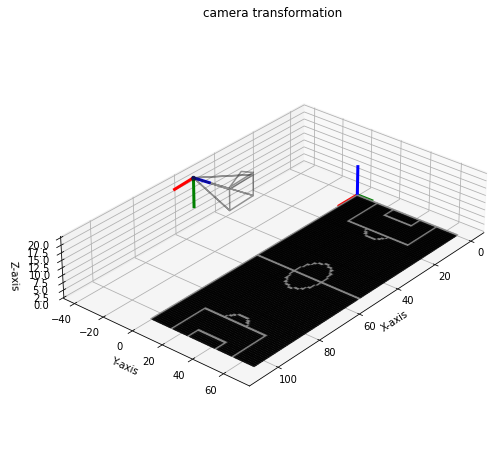

In [44]:
img_soccer = cv2.cvtColor(img_soccer_field, cv2.COLOR_BGR2RGB)
img_soccer = np.transpose(img_soccer, (1, 0, 2))

plt.close('all')
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set(xlim=(-5, img_soccer.shape[0] + 5), ylim=(-45, img_soccer.shape[1] + 5), zlim=(0, 20))
ax = pytransform3d.rotations.plot_basis(
    ax,
    s=10, # 基坐标大小
    lw=3,
)

Rx_neg_90 = pytransform3d.rotations.active_matrix_from_angle(0, np.deg2rad(-90))
Ry_pos_00 = pytransform3d.rotations.active_matrix_from_angle(1, np.deg2rad(0))
Rz_pos_05 = pytransform3d.rotations.active_matrix_from_angle(2, np.deg2rad(5))
# R = pytransform3d.rotations.active_matrix_from_extrinsic_euler_xyz((np.deg2rad(-90), 0, np.deg2rad(5)))
R_c = Rz_pos_05 @ Ry_pos_00 @ Rx_neg_90 
C = worldcup_camera_parameter['cc_mean'][0]
ax = pytransform3d.rotations.plot_basis(
    ax,
    s=10, lw=3,
    R=R_c,
    p=C,
    # label='Camera PTZ'
)
xx, yy = np.ogrid[0:img_soccer.shape[0], 0:img_soccer.shape[1]]
# 设置x,y,z坐标轴刻度等大小
ax.set_box_aspect((np.ptp(xx), np.ptp(yy), 20))
ax.plot_surface(xx, yy, np.atleast_2d(0), alpha=0.75, rstride=1, cstride=1, facecolors=img_soccer.astype(np.float32) / 255.0)

# Camera
f = worldcup_camera_parameter['fl_mean'][0][0]
sensor_size = (1280, 720)
intrinsic_matrix = np.array([
    [f, 0, sensor_size[0] / 2],
    [0, f, sensor_size[1] / 2],
    [0, 0, 1.0]
], dtype=np.float32)

# H(p) @ H(R)
cam2world = pytransform3d.transformations.transform_from(R=R_c, p=C)
pytransform3d.camera.plot_camera(
    ax=ax,
    cam2world=cam2world,
    M=intrinsic_matrix, 
    sensor_size=sensor_size, # TODO
    virtual_image_distance=30,
    alpha=0.45, color='#181818'
)
ax.view_init(elev=30, azim=40, vertical_axis='z')
ax.set_title("camera transformation")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
R_c, C

### Camera Pose

Let $C$ be a column vector describing the location of the camera-center in world coordinates, and let $R_c$
be the rotation matrix describing the camera's orientation with respect to the world coordinate axes.

In [45]:
R_h = np.eye(4)
R_h[:3, :3] = R_c
R_h

array([[ 0.996195, -0.      , -0.087156,  0.      ],
       [ 0.087156,  0.      ,  0.996195,  0.      ],
       [ 0.      , -1.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  1.      ]])

In [46]:
C_h = np.eye(4)
C_h[:3, -1] = C
C_h

array([[  1.      ,   0.      ,   0.      ,  52.366185],
       [  0.      ,   1.      ,   0.      , -45.156501],
       [  0.      ,   0.      ,   1.      ,  16.821567],
       [  0.      ,   0.      ,   0.      ,   1.      ]])

In [47]:
Pose = C_h @ R_h
Pose

array([[  0.996195,  -0.      ,  -0.087156,  52.366185],
       [  0.087156,   0.      ,   0.996195, -45.156501],
       [  0.      ,  -1.      ,   0.      ,  16.821567],
       [  0.      ,   0.      ,   0.      ,   1.      ]])

In [48]:
Pose.T, np.linalg.inv(Pose)

(array([[  0.996195,   0.087156,   0.      ,   0.      ],
        [ -0.      ,   0.      ,  -1.      ,   0.      ],
        [ -0.087156,   0.996195,   0.      ,   0.      ],
        [ 52.366185, -45.156501,  16.821567,   1.      ]]),
 array([[  0.996195,   0.087156,   0.      , -48.231267],
        [ -0.      ,   0.      ,  -1.      ,  16.821567],
        [ -0.087156,   0.996195,   0.      ,  49.548681],
        [  0.      ,   0.      ,   0.      ,   1.      ]]))

### Camera Extrinsic Pose

Describes how to transform points in world coordinates to camera coordinates. The vector $t$ can be interpreted as the position of the world origin in camera coordinates, and the columns of $R$ represent represent the directions of the world-axes in camera coordinates.

The extrinsic matrix is obtained by inverting the camera's pose matrix.

In [49]:
R = R_c.T
t = -R_c.T @ C
R, t

(array([[ 0.996195,  0.087156,  0.      ],
        [-0.      ,  0.      , -1.      ],
        [-0.087156,  0.996195,  0.      ]]),
 array([-48.231267,  16.821567,  49.548681]))

## Search Feature

In [50]:
query_index = 15
struct_void = test_UoT['annotation'][0][query_index]
type(struct_void), struct_void['image_name'], struct_void['homography']

(numpy.void,
 array(['16.jpg'], dtype='<U6'),
 array([[ 11.11628 ,  -6.766282, 188.062353],
        [  0.440481,   0.381525, 127.388439],
        [ -0.000302,  -0.003024,   0.402609]]))

In [51]:
# ground truth homography
test_image_name, test_gt_h = struct_void
test_image_name, test_gt_h

(array(['16.jpg'], dtype='<U6'),
 array([[ 11.11628 ,  -6.766282, 188.062353],
        [  0.440481,   0.381525, 127.388439],
        [ -0.000302,  -0.003024,   0.402609]]))

In [52]:
testset_features['features'].shape, database_camera_features['features'].shape

((16, 186), (91173, 16))

In [53]:
database_features, testset_feature_x = database_camera_features['features'], testset_features['features'][:, query_index]
testset_feature_x

array([ 0.025688, -0.233451, -0.096971, -0.20187 , -0.0677  ,  0.410727,
       -0.082704,  0.275503,  0.354157,  0.520592,  0.193371,  0.137005,
        0.227932, -0.352738, -0.097878,  0.008252], dtype=float32)

In [54]:
# %%timeit

# get the similar camera feature from feature database
flann = pyflann.FLANN()
result, _ = flann.nn(database_features, testset_feature_x, 1, algorithm="kdtree", trees=8, checks=64)
result

array([74009], dtype=int32)

In [55]:
retrieved_camera_param = database_camera_features['cameras'][result[0]]
retrieved_camera_param

array([ 640.      ,  360.      , 4444.471781,    1.674882,    0.29559 ,
         -0.259898,   51.736009,  -54.392403,   14.967156])

(None,
 array([ 640.      ,  360.      , 4444.471781,    1.674882,    0.29559 ,
          -0.259898,   51.736009,  -54.392403,   14.967156]),
 (720, 1280, 3))

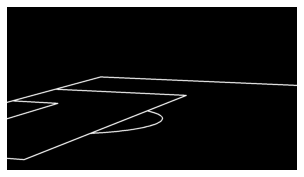

In [56]:
retrieved_image = SyntheticUtil.camera_to_edge_image(
    retrieved_camera_param, worldcup_2014_mat['points'], worldcup_2014_mat['line_segment_index'],
    im_h=720, im_w=1280, line_width=4)

_imshow(retrieved_image), retrieved_camera_param, retrieved_image.shape

(None,
 array([ 0.025688, -0.233451, -0.096971, -0.20187 , -0.0677  ,  0.410727,
        -0.082704,  0.275503,  0.354157,  0.520592,  0.193371,  0.137005,
         0.227932, -0.352738, -0.097878,  0.008252], dtype=float32))

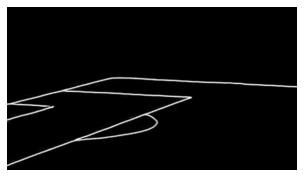

In [57]:
_imshow(testset_features['edge_map'][..., query_index]), testset_features['features'][..., query_index]

In [58]:
_print_dictkeys_shape(worldcup_2014_mat)

points: (302, 2)
line_segment_index: (151, 2)
grid_points: (2204, 2)


In [59]:
_print_dictkeys_shape(testset_features)

edge_distances: (180, 320, 1, 186)
edge_map: (720, 1280, 1, 186)
features: (16, 186)


##  Code Refacting

### Camera Class

In [62]:
@dataclass
class CameraProp(object):
    fl: float
    cx: float
    cy: float
    skew: float = 0.
    aspect: float = 1.


# This is **Extrinsic Pose**, not the camera pose with respect to the world.
class CameraPose(object):
    '''
    This is the camera extrinsic pose. Here is not the linear transform matrix (Camera Pose Transform)
    https://ksimek.github.io/2012/08/22/extrinsic/
    TODO the class name is not good. so easy to confuse the transform and extrinsic
    '''

    @classmethod
    def from_axis_angle(cls, r, t):
        return CameraPose(cv2.Rodrigues(np.array(r))[0], np.array(t))

    @classmethod
    def from_axis_xyz(cls, degrees, order, offset):
        assert len(degrees) == len(order)
        rmat = np.identity(3)
        for degree, axis in zip(degrees, order):
            angle = np.radians(degree)
            s, c = np.sin(angle), np.cos(angle)
            if axis == 'x':
                rmat = rmat @ np.asarray([[1, 0, 0], [0, c, -s], [0, s, c]])
            elif axis == 'y':
                rmat = rmat @ np.asarray([[c, 0, s], [0, 1, 0], [-s, 0, c]])
            elif axis == 'z':
                rmat = rmat @ np.asarray([[c, -s, 0], [s, c, 0], [0, 0, 1]])
        return CameraPose(rmat, offset).I  # Must

    def __init__(self, r, t):
        self.r = r
        self.t = np.asarray(t).reshape(3, 1)

    @property
    def I(self):  # noqa: E743
        '''
        http://assets.erlangai.cn/Misc/camera/Extrinsic_Matrix_from_Camera_Pose.png
        '''
        return CameraPose(self.r.T, - (self.r.T @ self.t))

    @property
    def E(self):
        '''
        Return: camera extrinsic matrix
        '''
        return np.hstack((self.r, self.t))

    def __matmul__(self, other):
        '''
        | Rl  Cl  |    | Rr  Cr  |   | Rl Rr  RlCr +_Cl |
        |         | @  |         | = |                  |
        | 0    1  |    | 0    1  |   |   0        1     |
        '''
        return CameraPose(self.r @ other.r, self.r @ other.t + self.t)

    def __repr__(self):
        return f'R:\n{self.r}\nT:\n{self.t}'


class PerspectiveCamera:

    def __init__(self, prop:CameraProp, pose:CameraPose):
        '''
        | fl  s   cx |
        | 0  a*fl cy |
        | 0   0    1 |
        '''
        self.K = np.asarray([[prop.fl, prop.skew, prop.cx], [0, prop.aspect * prop.fl, prop.cy], [0, 0, 1]])
        self.E = pose.E
        self.P = self.K @ self.E

    def project_3d(self, pts_3d: np.ndarray):
        '''
        pts_3d: N x 3
        pts_2d: N x 2 
        '''
        pts_3d_hg = np.hstack((pts_3d, np.ones((pts_3d.shape[0], 1)))) # N x 4
        pts_2d = pts_3d_hg @ self.P.T  # (P @ H^T)^T --> H @ P^T
        pts_2d[:, 0] /= pts_2d[:, 2]
        pts_2d[:, 1] /= pts_2d[:, 2]
        return pts_2d[:, 0:2]
    
    def get_homography(self):
        """
        homography matrix from the projection matrix
        https://towardsdatascience.com/estimating-a-homography-matrix-522c70ec4b2c
        """
        return self.P[:, [0, 1, 3]]

    def __repr__(self):
        return f'K:\n{self.K}\nE:\n{self.E}'

#### Test CameraPose VS RotationUtil

In [63]:
fl = 3081.976880
cx, cy = 640, 360
offset = np.asarray([52.816224, -54.753716, 19.960425])
rotx, roty, rotz = -90, 0.2, 0
pany, tiltx = 25, -10
point3d = np.asarray([[10, 20, 0]])

In [64]:
prop = CameraProp(fl, cx, cy) 
base_pose = CameraPose.from_axis_xyz([rotx, roty, rotz], order='xyz', offset=offset)
pan_tilt_pose = CameraPose.from_axis_xyz([pany, tiltx], order='yx', offset=[0, 0, 0])
pose = pan_tilt_pose @ base_pose

In [65]:
base_pose.r, pose.r, cv2.Rodrigues(pose.r)[0]

(array([[ 0.999994, -0.003491, -0.      ],
        [ 0.      ,  0.      , -1.      ],
        [ 0.003491,  0.999994,  0.      ]]),
 array([[ 0.904827, -0.425779, -0.      ],
        [-0.073936, -0.157122, -0.984808],
        [ 0.419311,  0.891081, -0.173648]]),
 array([[ 1.713937],
        [-0.38311 ],
        [ 0.321468]]))

In [66]:
base_rotation = RotationUtil.rotate_z_axis(rotz) @ RotationUtil.rotate_y_axis(roty) @ RotationUtil.rotate_x_axis(rotx)
pan_tilt_rotation = RotationUtil.pan_y_tilt_x(pany, tiltx)
rotation = pan_tilt_rotation @ base_rotation
rot_vec, _ = cv2.Rodrigues(rotation)
base_rotation, rotation, rot_vec

(array([[ 0.999994, -0.003491, -0.      ],
        [ 0.      ,  0.      , -1.      ],
        [ 0.003491,  0.999994,  0.      ]]),
 array([[ 0.904827, -0.425779, -0.      ],
        [-0.073936, -0.157122, -0.984808],
        [ 0.419311,  0.891081, -0.173648]]),
 array([[ 1.713937],
        [-0.38311 ],
        [ 0.321468]]))

#### Test PerspectiveCamera VS ProjectiveCamera

In [67]:
camera = PerspectiveCamera(prop, pose)
camera.P, camera.project_3d(point3d)

(array([[   3057.014934,    -741.950287,    -111.134834, -199866.22233 ],
        [    -76.916551,    -163.455992,   -3097.66807 ,   56943.390041],
        [      0.419311,       0.891081,      -0.173648,      30.10966 ]]),
 array([[-3532.609351,  1014.978074]]))

In [68]:
camera2 = ProjectiveCamera(fl, cx, cy, offset, rot_vec)
camera2.P, camera2.project_3d(point3d[0][0], point3d[0][1], point3d[0][2], 1)

(array([[   3057.014934,    -741.950287,    -111.134834, -199866.22233 ],
        [    -76.916551,    -163.455992,   -3097.66807 ,   56943.390041],
        [      0.419311,       0.891081,      -0.173648,      30.10966 ]]),
 (-3532.6093505584568, 1014.9780739458458))

#### Test Homegraphy

![](http://assets.erlangai.cn/Misc/camera/homography.png)

In [ ]:
H = camera.get_homography()
H_inv = np.linalg.inv(H)
H, H.T, H_inv

In [ ]:
H2 = camera2.get_homography()
H2_inv = np.linalg.inv(H2)
H2, H2.T, H2_inv

In [ ]:
img16 = cv2.imread(f'{TOP_DIR}/data/UoT_soccer/16.jpg')
_imshow(img16, figsize=(12, 8))

In [ ]:
scale = 10
S10 = np.array([[scale, 0, 0], [0, scale, 0], [0, 0, 1]])
S10

In [ ]:
imgwraped = cv2.warpPerspective(img16, S10 @ H_inv, (scale * template_w, scale * template_h), borderMode=cv2.BORDER_CONSTANT, borderValue=0)
_imshow(imgwraped, figsize=(12, 8))

### Synthetic Class

In [69]:
Stats = namedtuple('Stats', ['mean', 'std', 'min', 'max'], defaults=[0] * 4)
MotionStd = namedtuple('MotionStd', ['fl', 'pan', 'tilt'], defaults=[0] * 3)
Point = namedtuple('Point', ['x', 'y'])
SoccerField = namedtuple('SoccerField', ['points', 'line_segment_index'])


@dataclass
class CameraMotionParameter(object):
    cc: Stats
    fl: Stats
    pan: Stats
    roll: Stats
    tilt: Stats


class SyntheticDataset(object):
    def __init__(self):
        pass

    @staticmethod
    def generate_ptz_cameras(motion_param:CameraMotionParameter, image_size:tuple, camera_num:int):
        rnd_normal = lambda stat, size: np.random.normal(stat.mean, stat.std, (camera_num, size))
        rnd_uniform = lambda stat: np.random.uniform(stat.min, stat.max, camera_num)
        ccs = rnd_normal(motion_param.cc, 3)
        fls = rnd_normal(motion_param.fl, 1)
        rolls = rnd_uniform(motion_param.roll)  # z-axis when in base axis, y-axis when in world axis
        pans = rnd_uniform(motion_param.pan)    # y-axis when in base axis
        tilts = rnd_uniform(motion_param.tilt)  # x-axis when in base axis
        cx, cy = image_size[0] / 2, image_size[1] / 2

        cameras = np.zeros((camera_num, 9))
        for i in range(camera_num):
            axis_base_world = CameraPose.from_axis_xyz([-90, rolls[i], 0], order='xyz', offset=ccs[i])
            axis_camera_base = CameraPose.from_axis_xyz([pans[i], tilts[i]], order='yx', offset=[0, 0, 0])
            axis_camera_world = axis_camera_base @ axis_base_world
            r = cv2.Rodrigues(axis_camera_world.r)[0]
            t = axis_camera_world.t
            cameras[i][0], cameras[i][1], cameras[i][2] = cx, cy, fls[i]
            cameras[i][3], cameras[i][4], cameras[i][5] = r[0], r[1], r[2]
            cameras[i][6], cameras[i][7], cameras[i][8] = t[0][0], t[1][0], t[2][0]
        return cameras

    def generate_camera_pair(motion_param:CameraMotionParameter, motion_std:MotionStd, image_size:tuple, camera_num:int):
        rnd_normal = lambda stat, size: np.random.normal(stat.mean, stat.std, (camera_num, size))
        rnd_uniform = lambda stat: np.random.uniform(stat.min, stat.max, camera_num)
        rnd_nearby = lambda d, std: d + np.random.uniform(-0.5, 0.5, 1) * std

        ccs = rnd_normal(motion_param.cc, 3)
        fls = rnd_normal(motion_param.fl, 1)
        rolls = rnd_uniform(motion_param.roll)  # z-axis when in base axis, y-axis when in world axis
        pans = rnd_uniform(motion_param.pan)    # y-axis when in base axis
        tilts = rnd_uniform(motion_param.tilt)  # x-axis when in base axis

        fls_nb = rnd_nearby(fls, motion_std.fl)
        pans_nb = rnd_nearby(pans, motion_std.pan)
        tilts_nb = rnd_nearby(tilts, motion_std.tilt)

        cx, cy = image_size[0] / 2, image_size[1] / 2

        cams_pivot, cams_positive = np.zeros((camera_num, 9)), np.zeros((camera_num, 9))
        
        def _get_transform_matrix(axis_base_world, pan, tilt):
            axis_camera_base = CameraPose.from_axis_xyz([pan, tilt], order='yx', offset=[0, 0, 0])
            axis_camera_world = axis_camera_base @ axis_base_world
            return cv2.Rodrigues(axis_camera_world.r)[0], axis_camera_world.t.reshape(-1)

        for i in range(camera_num):
            axis_base_world = CameraPose.from_axis_xyz([-90, rolls[i], 0], order='xyz', offset=ccs[i])
            r, t = _get_transform_matrix(axis_base_world, pans[i], tilts[i])
            cams_pivot[i][0], cams_pivot[i][1], cams_pivot[i][2] = cx, cy, fls[i]
            cams_pivot[i][3], cams_pivot[i][4], cams_pivot[i][5] = r[0], r[1], r[2]
            cams_pivot[i][6], cams_pivot[i][7], cams_pivot[i][8] = t[0], t[1], t[2]
            
            r, t = _get_transform_matrix(axis_base_world, pans_nb[i], tilts_nb[i])
            cams_positive[i][0], cams_positive[i][1], cams_positive[i][2] = cx, cy, fls_nb[i]
            cams_positive[i][3], cams_positive[i][4], cams_positive[i][5] = r[0], r[1], r[2]
            cams_positive[i][6], cams_positive[i][7], cams_positive[i][8] = t[0], t[1], t[2]

        return cams_pivot, cams_positive

    @staticmethod
    def generate_camera_image(camera_data:np.ndarray, soccer_field:SoccerField, image_size:tuple, thickness=4):
        """
        生成摄像机角度里的球场边线图像
        """
        prop = CameraProp(cx=camera_data[0], cy=camera_data[1], fl=camera_data[2])
        pose = CameraPose.from_axis_angle(camera_data[3:6], camera_data[6:9])
        camera = PerspectiveCamera(prop, pose)

        image = np.zeros((image_size[1], image_size[0], 3), dtype=np.uint8)
        color = (255, 255, 255)
        points = soccer_field.points
        segmts = soccer_field.line_segment_index
        pts_3d = np.hstack((points, np.ones((points.shape[0], 1))))
        pts_2d = camera.project_3d(pts_3d)
        for idx1, idx2 in segmts:
            p1, p2 = np.rint(pts_2d[idx1]).astype(np.int32), np.rint(pts_2d[idx2]).astype(np.int32)
            cv2.line(image, tuple(p1), tuple(p2), color, thickness=thickness)
        return image


#### PTZ Cameras Parameters

In [70]:
wcp = worldcup_camera_parameter
num = 5 * 2

motion_param = CameraMotionParameter(
    cc = Stats(wcp['cc_mean'][0], wcp['cc_std'][0], wcp['cc_min'][0], wcp['cc_max'][0]),
    fl = Stats(wcp['fl_mean'][0], wcp['fl_std'][0], wcp['fl_min'][0], wcp['fl_max'][0]),
    pan = Stats(min=-35.0, max=35.0),
    roll = Stats(0, 0.2, -1.0, 1.0),
    tilt = Stats(min=-15.0, max=-5.0)
)

cameras = SyntheticDataset.generate_ptz_cameras(motion_param, (WIDTH, HEIGHT), num)

In [71]:
soccer_field = SoccerField(worldcup_2014_mat['points'], worldcup_2014_mat['line_segment_index'])
image_edges = []
for i, camera_data in enumerate(cameras):
    image_edges.append(SyntheticDataset.generate_camera_image(camera_data, soccer_field, (WIDTH, HEIGHT), thickness=4))

In [ ]:
meld_image = np.vstack((np.hstack(image_edges[:num//2]), np.hstack(image_edges[num//2:])))
_imshow(meld_image, figsize=(16, 8))

#### Pivot and Positive Cameras

In [ ]:
motion_std = MotionStd(30, 1.5, 0.75)
cams_pivot, cams_positive = SyntheticDataset.generate_camera_pair(motion_param, motion_std, image_size=(WIDTH, HEIGHT), camera_num=num)
cams_pivot.shape, cams_positive.shape

In [ ]:
np.random.seed(123456)
indices = np.random.choice(num, min(5, num//2), False)
pivot_edges, positive_edges = [], []
for i in indices:
    pivot_edges.append(SyntheticDataset.generate_camera_image(cams_pivot[i], soccer_field, (WIDTH, HEIGHT), thickness=4))
    positive_edges.append(SyntheticDataset.generate_camera_image(cams_positive[i], soccer_field, (WIDTH, HEIGHT), thickness=4))

In [ ]:
meld_image = np.vstack((np.hstack(pivot_edges), np.hstack(positive_edges)))
_imshow(meld_image, figsize=(16, 8))

#### Synthetic Siamese Network Dataset

In [74]:
camera_parameter_file = f'{TOP_DIR}/data/worldcup_dataset_camera_parameter.mat'
soccer_field_template_file = f'{TOP_DIR}/data/worldcup2014.mat'
dataset_sample_file = f'{TOP_DIR}/data/dataset_sample.mat'

def generate_siamese_dataset(camera_parameter_file, soccer_field_template_file, output_file = None, image_size=(320, 180), image_num=10000):
    camera_param = sio.loadmat(camera_parameter_file)
    motion_param = CameraMotionParameter(
        cc = Stats(camera_param['cc_mean'][0], camera_param['cc_std'][0], camera_param['cc_min'][0], camera_param['cc_max'][0]),
        fl = Stats(camera_param['fl_mean'][0], camera_param['fl_std'][0], camera_param['fl_min'][0], camera_param['fl_max'][0]),
        pan = Stats(min=-35.0, max=35.0),
        roll = Stats(0, 0.2, -1.0, 1.0),
        tilt = Stats(min=-15.0, max=-5.0)
    )
    motion_std = MotionStd(30, 1.5, 0.75)
    
    ground_templ = sio.loadmat(soccer_field_template_file)
    soccer_field = SoccerField(ground_templ['points'], ground_templ['line_segment_index'])
    cams_pivot, cams_positive = SyntheticDataset.generate_camera_pair(motion_param, motion_std, image_size=(1280, 720), camera_num=image_num)
    
    image_piv_list, image_pos_list = [], []
    for i in range(image_num):
        image_piv = SyntheticDataset.generate_camera_image(cams_pivot[i], soccer_field, (1280, 720), thickness=4)
        image_pos = SyntheticDataset.generate_camera_image(cams_positive[i], soccer_field, (1280, 720), thickness=4)
        image_piv = cv2.cvtColor(cv2.resize(image_piv, image_size, interpolation=interpolation), cv2.COLOR_BGR2GRAY)
        image_pos = cv2.cvtColor(cv2.resize(image_pos, image_size, interpolation=interpolation), cv2.COLOR_BGR2GRAY)
        image_piv_list.append(image_piv)
        image_pos_list.append(image_pos)
  
    image_np = np.asarray(image_piv_list) / 255
    dataset = {
        'pivot_images': np.asarray(image_piv_list),
        'positive_images': np.asarray(image_pos_list),
        'pivot_camera': cams_pivot,
        'image_mean': np.mean(image_np),
        'image_std': np.std(image_np)
    }
    if output_file is not None:
        sio.savemat(output_file, dataset)
    return dataset

In [75]:
generate_siamese_dataset(camera_parameter_file, soccer_field_template_file, dataset_sample_file, image_num=500)
dataset_sample = sio.loadmat(dataset_sample_file)
_print_dictkeys_shape(dataset_sample)

pivot_images: (500, 180, 320)
positive_images: (500, 180, 320)
pivot_camera: (500, 9)
image_mean: (1, 1)
image_std: (1, 1)


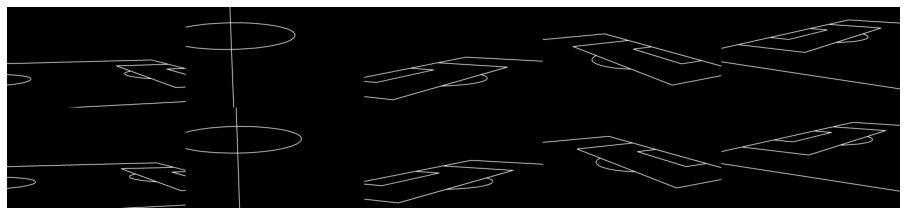

In [76]:
meld_image = np.vstack((np.hstack(dataset_sample['pivot_images'][:5]), np.hstack(dataset_sample['positive_images'][:5])))
_imshow(meld_image, color='gray', figsize=(16, 8))

### Dataset Loader

In [77]:
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.utils import make_grid 
from torch.utils.data import (Dataset, DataLoader)
from collections import namedtuple
from PIL import Image


CameraPair = namedtuple('CameraPair', ['anchor_images', 'positive_images'])

class CameraPairDataset(Dataset):

    def __init__(self, data:CameraPair, transform=None):
        self.data = data
        self.size = len(self.data.anchor_images)
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((180, 320)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.0188], std=[0.128])
            ])
        else:
            self.transform = transform

        #
        # | 0, 1, 2, ..., N, 0, 1, 2, ..., N | --> x1
        # | 0, 1, 2, ..., N, roll(shift=1)   | --> x2
        # | 1, 1, 1, ..., 1, 0, 0, 0, ..., 0 | --> label
        #
        rng = np.random.default_rng(seed=123456)
        indices = rng.permutation(self.size)
        x1_inputs = np.concatenate((indices, indices), axis=0).reshape(-1, 1)
        x2_inputs = np.concatenate((indices, np.roll(indices, shift=1)), axis=0).reshape(-1, 1)
        self.indices = rng.permutation(np.concatenate((x1_inputs, x2_inputs), axis=1))

    def __len__(self):
        return 2 * self.size

    def __getitem__(self, index):
        ix1, ix2 = self.indices[index]
        x1 = self.data.anchor_images[ix1]
        x2 = self.data.anchor_images[ix2] if ix1 != ix2 else self.data.positive_images[ix2]
        return (self.transform(Image.fromarray(x1)), \
                self.transform(Image.fromarray(x2)), \
                torch.from_numpy(np.array([int(ix1 == ix2)], dtype=np.float32)))

#### Test Iterator

In [78]:
data_transform = transforms.Compose([
    transforms.Resize((180, 320)), # H, W
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_sample['image_mean'], std=dataset_sample['image_std'])
])
data = CameraPair(anchor_images=dataset_sample['pivot_images'], positive_images=dataset_sample['positive_images'])
dataset = CameraPairDataset(data, transform=data_transform)
len(dataset), dataset_sample['pivot_camera'][0]

(1000,
 array([ 640.      ,  360.      , 3085.863852,    1.65295 ,   -0.211393,
           0.192779,  -66.23971 ,   10.337192,   51.208734]))

In [79]:
nrow = 5
train_loader = DataLoader(dataset, batch_size=nrow, shuffle=True, num_workers=4)
for bx1, bx2, bla in train_loader:
    print(bx1.shape, bx2.shape, bla)
    break
bx1, bx2, bla = next(iter(train_loader))
bx1.shape, bx2.shape, bla

torch.Size([5, 1, 180, 320]) torch.Size([5, 1, 180, 320]) tensor([[0.],
        [0.],
        [1.],
        [0.],
        [0.]])


(torch.Size([5, 1, 180, 320]),
 torch.Size([5, 1, 180, 320]),
 tensor([[1.],
         [0.],
         [0.],
         [1.],
         [1.]]))

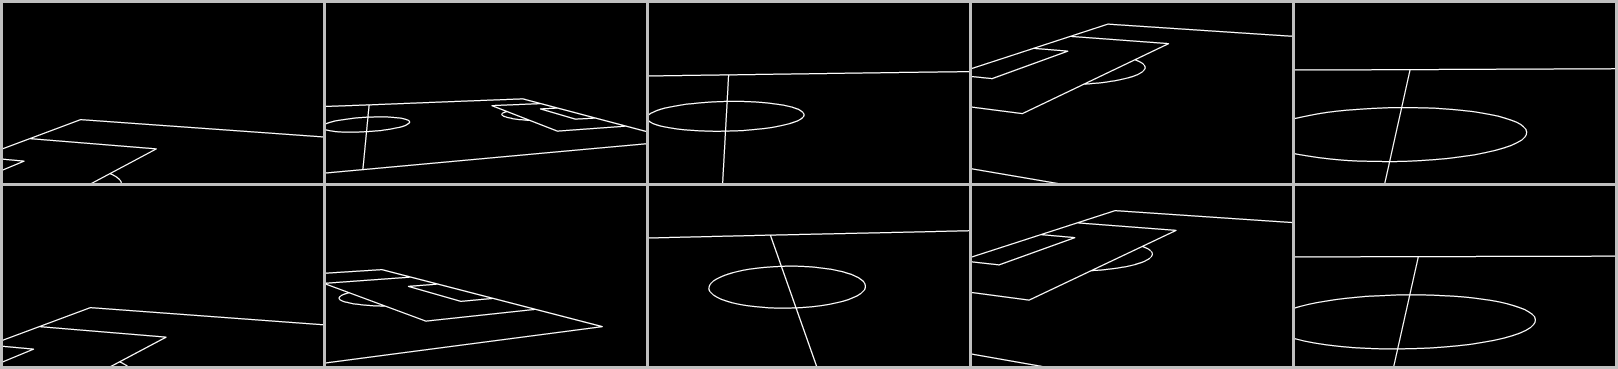

(torch.Size([3, 369, 1618]), None)

In [80]:
grid_image = make_grid(torch.cat((bx1, bx2), dim=0), nrow=nrow, padding=3, normalize=True, pad_value=0.75)
grid_pil_image = transforms.ToPILImage()(grid_image)
grid_image.shape, grid_pil_image.convert('L').show()

#### Convert cv2 / PIL / Tensor

In [81]:
img36 = np.arange(36, dtype=np.uint8).reshape((6,6))
cv_img = img36 
type(cv_img), cv_img.shape, cv_img

(numpy.ndarray,
 (6, 6),
 array([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22, 23],
        [24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35]], dtype=uint8))

In [82]:
pil_img = Image.fromarray(cv_img)
type(pil_img), pil_img.width, pil_img.height

(PIL.Image.Image, 6, 6)

In [83]:
tsr_img = torch.from_numpy(cv_img)
tsr_cv_img = transforms.ToTensor()(cv_img) # range: [0, 1]
tsr_pil_img = transforms.ToTensor()(pil_img)
tsr_img, tsr_cv_img.shape, tsr_cv_img, tsr_pil_img.shape, tsr_pil_img

(tensor([[ 0,  1,  2,  3,  4,  5],
         [ 6,  7,  8,  9, 10, 11],
         [12, 13, 14, 15, 16, 17],
         [18, 19, 20, 21, 22, 23],
         [24, 25, 26, 27, 28, 29],
         [30, 31, 32, 33, 34, 35]], dtype=torch.uint8),
 torch.Size([1, 6, 6]),
 tensor([[[0.0000, 0.0039, 0.0078, 0.0118, 0.0157, 0.0196],
          [0.0235, 0.0275, 0.0314, 0.0353, 0.0392, 0.0431],
          [0.0471, 0.0510, 0.0549, 0.0588, 0.0627, 0.0667],
          [0.0706, 0.0745, 0.0784, 0.0824, 0.0863, 0.0902],
          [0.0941, 0.0980, 0.1020, 0.1059, 0.1098, 0.1137],
          [0.1176, 0.1216, 0.1255, 0.1294, 0.1333, 0.1373]]]),
 torch.Size([1, 6, 6]),
 tensor([[[0.0000, 0.0039, 0.0078, 0.0118, 0.0157, 0.0196],
          [0.0235, 0.0275, 0.0314, 0.0353, 0.0392, 0.0431],
          [0.0471, 0.0510, 0.0549, 0.0588, 0.0627, 0.0667],
          [0.0706, 0.0745, 0.0784, 0.0824, 0.0863, 0.0902],
          [0.0941, 0.0980, 0.1020, 0.1059, 0.1098, 0.1137],
          [0.1176, 0.1216, 0.1255, 0.1294, 0.1333, 0.1373]

In [84]:
check_diff = tsr_cv_img == tsr_pil_img
torch.all(check_diff), np.all(check_diff.numpy()) 

(tensor(True), True)

---------

If you are enlarging the image, you should prefer to use INTER_LINEAR or INTER_CUBIC interpolation. If you are shrinking the image, you should prefer to use INTER_AREA interpolation.

In [85]:
# transforms only input Pil or tensor type
T_resize = transforms.Resize((3, 3), interpolation=transforms.InterpolationMode.BILINEAR)
T_tensor = transforms.ToTensor()
Image.BILINEAR, transforms.InterpolationMode.BILINEAR.value, cv2.INTER_LINEAR, cv2.INTER_AREA

(2, 'bilinear', 1, 3)

In [86]:
pil_resize_img = T_resize(pil_img)
tsr_pil_resize_img = T_tensor(pil_resize_img)
type(pil_resize_img), pil_resize_img.width, pil_resize_img.height, \
tsr_pil_resize_img.shape, tsr_pil_resize_img

(PIL.Image.Image,
 3,
 3,
 torch.Size([1, 3, 3]),
 tensor([[[0.0196, 0.0275, 0.0314],
          [0.0627, 0.0706, 0.0745],
          [0.1059, 0.1137, 0.1176]]]))

In [87]:
np.array(pil_resize_img), cv2.resize(cv_img, (3, 3), interpolation=cv2.INTER_AREA)

(array([[ 5,  7,  8],
        [16, 18, 19],
        [27, 29, 30]], dtype=uint8),
 array([[ 4,  6,  8],
        [16, 18, 20],
        [28, 30, 32]], dtype=uint8))

-----------------

In [88]:
tsr_chnl_img = tsr_img[None,::]
tsr_chnl_resize_img = T_resize(tsr_chnl_img)
tsr_tsr_resize_img = T_tensor(tsr_chnl_resize_img.numpy())
tsr_chnl_img, tsr_chnl_resize_img, tsr_tsr_resize_img

(tensor([[[ 0,  1,  2,  3,  4,  5],
          [ 6,  7,  8,  9, 10, 11],
          [12, 13, 14, 15, 16, 17],
          [18, 19, 20, 21, 22, 23],
          [24, 25, 26, 27, 28, 29],
          [30, 31, 32, 33, 34, 35]]], dtype=torch.uint8),
 tensor([[[ 4,  6,  8],
          [16, 18, 20],
          [28, 30, 32]]], dtype=torch.uint8),
 tensor([[[0.0157, 0.0627, 0.1098]],
 
         [[0.0235, 0.0706, 0.1176]],
 
         [[0.0314, 0.0784, 0.1255]]]))

## Siamese Model

### Network 

In [89]:
import torch.nn as nn

class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin:float):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, x1, x2, label):
        """
        similar:1, dissimilar:0
        """
        dist = F.pairwise_distance(x1, x2, keepdim=True)
        loss = torch.mean(
            label * torch.pow(dist, 2) + \
                (1 - label) * torch.pow(torch.clamp(self.margin - dist, min=0.0), 2)
        )
        return loss


class SiameseNetwork(nn.Module):
    def __init__(self):
        """
        inputs: (B, 1, 180, 320)

        filter_feature_size: W / ((K - 2 * Pad) * S), H / ((K - 2 * Pad) * S)
        """
        super(SiameseNetwork, self).__init__()
        self.extract_features = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=7, stride=2, padding=3), nn.LeakyReLU(0.1, inplace=True),
            # (B, 4, 90, 160)
            nn.Conv2d(4, 8, kernel_size=5, stride=2, padding=2), nn.ReLU(inplace=True),
            # (B, 8, 45, 80)
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1), nn.ReLU(inplace=True),
            # (B, 16, 23, 40)
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), nn.ReLU(inplace=True),
            # (B, 32, 12, 20)
            nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1), nn.ReLU(inplace=True),
            # (B, 16, 6, 10)
            nn.Dropout(p=0.3),
        )
        self.fc = nn.Sequential(
            # nn.Linear(960, 16), # 960: 6 * 10 * 16
            nn.Linear(960, 480), nn.ReLU(inplace=True), nn.Dropout(p=0.5),
            nn.Linear(480, 240), nn.ReLU(inplace=True), # nn.Dropout(p=0.5),
            nn.Linear(240, 16)
        )

    def _forward_once(self, x):
        x = self.extract_features(x)
        x = self.fc(x.view(x.size(0), -1))
        x = nn.functional.normalize(x, p=2, dim=1)
        return x

    def forward(self, x1, x2):
        x1 = self._forward_once(x1)
        x2 = self._forward_once(x2)
        return x1, x2

In [90]:
from torchsummary import summary

siamese = SiameseNetwork()
print(siamese)
summary(SiameseNetwork(), input_size=[(1, 180, 320), (1, 180, 320)], batch_size=1)

SiameseNetwork(
  (extract_features): Sequential(
    (0): Conv2d(1, 4, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): Conv2d(4, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): ReLU(inplace=True)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Dropout(p=0.3, inplace=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=960, out_features=480, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=480, out_features=240, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=240, out_features=16, bias=True)
  )
)
----------------------------------------------------------------


### Train

In [91]:
import torch.optim as optim
import torch.backends.cudnn as cudnn

model_save_path = f'{CKPTS_DIR}/siamese_10000.pth'

In [92]:
epoch_beg = 0
epoch_num = 5 
learning_rate = 0.01

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:{}'.format(args.cuda_id))
    cudnn.benchmark = True

model_state_dict, optim_state_dict = None, None
if os.path.exists(model_save_path):
    ckpts = torch.load(model_save_path, map_location=device)
    model_state_dict, optim_state_dict, epoch_beg = ckpts['model'], ckpts['optimizer'], ckpts['epoch']
epoch_beg, ckpts['epoch']

(71, 71)

In [93]:
criterion = ContrastiveLoss(margin=1.0).to(device)

siamese = SiameseNetwork().to(device)
if model_state_dict is not None:
    siamese.load_state_dict(model_state_dict)

# optimizer = optim.SGD(siamese.parameters(), lr=0.1, momentum=0.9)
optimizer = optim.Adam(siamese.parameters(), lr=learning_rate)
if optim_state_dict is not None:
    optimizer.load_state_dict(optim_state_dict)

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 50, 55, 130], gamma=0.1)

In [94]:
epoch = 0

for epoch in range(epoch_beg, epoch_beg + epoch_num + 1):
    siamese.train()
    losses, pos_dists, neg_dists = [], [], []
    for bx1, bx2, labels in train_loader:
        bx1, bx2, labels = bx1.to(device), bx2.to(device), labels.to(device)
        feat1, feat2 = siamese(bx1, bx2)
        loss = criterion(feat1, feat2, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        dist = F.pairwise_distance(feat1.detach(), feat2.detach(), keepdim=True)
        for l, d in zip(labels.detach().squeeze(), dist.squeeze()):
            pos_dists.append(d) if l == 1 else neg_dists.append(d)

    scheduler.step()

    dist_pos, dist_neg = torch.mean(torch.tensor(pos_dists)), torch.mean(torch.tensor(neg_dists))
    print('[%d] lr=[%.6f] loss[%.6f] pos_d[%.6f] neg_d[%.6f] ratio[%.6f]' % (
        epoch,
        optimizer.param_groups[0]['lr'],
        torch.mean(torch.tensor(losses)), dist_pos, dist_neg,
        dist_neg / (dist_pos + 0.000001) 
        ))

torch.save({
    'epoch': epoch,
    'model': siamese.state_dict(),
    'optimizer': optimizer.state_dict()
}, model_save_path)
epoch

[71] lr=[0.000100] loss[0.054579] pos_d[0.203921] neg_d[1.305292] ratio[6.400932]
[72] lr=[0.000100] loss[0.053360] pos_d[0.201985] neg_d[1.302481] ratio[6.448373]
[73] lr=[0.000100] loss[0.051266] pos_d[0.191194] neg_d[1.306740] ratio[6.834596]
[74] lr=[0.000100] loss[0.052864] pos_d[0.198998] neg_d[1.304001] ratio[6.552790]
[75] lr=[0.000100] loss[0.054293] pos_d[0.205535] neg_d[1.304083] ratio[6.344787]
[76] lr=[0.000100] loss[0.051889] pos_d[0.194518] neg_d[1.302185] ratio[6.694375]


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


76

### Test

#### Batch Test

In [95]:
test_sample = generate_siamese_dataset(camera_parameter_file, soccer_field_template_file, image_num=20)
_print_dictkeys_shape(test_sample)

pivot_images: (20, 180, 320)
positive_images: (20, 180, 320)
pivot_camera: (20, 9)
image_mean: ()
image_std: ()


In [96]:
data = CameraPair(anchor_images=test_sample['pivot_images'], positive_images=test_sample['positive_images'])
test_dataset = CameraPairDataset(data, transform=data_transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=1)
len(test_dataset)

40

In [97]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:{}'.format(args.cuda_id))
    cudnn.benchmark = True
    
model_state_dict = None
if os.path.exists(model_save_path):
    ckpts = torch.load(model_save_path, map_location=device)
    model_state_dict = ckpts['model']
else:
    raise
siamese = SiameseNetwork().to(device)
if model_state_dict is not None:
    siamese.load_state_dict(model_state_dict)

In [98]:
siamese.eval()
with torch.no_grad():
    pos_dists, neg_dists = [], []
    for bx1, bx2, labels in test_loader:
        bx1, bx2, labels = bx1.to(device), bx2.to(device), labels.to(device)
        feat1, feat2 = siamese(bx1, bx2)
        dist = F.pairwise_distance(feat1.detach(), feat2.detach(), keepdim=True)
        print(np.hstack((dist.numpy(), labels.numpy())))

[[1.877131 0.      ]
 [1.228255 0.      ]
 [0.133087 1.      ]
 [1.636111 0.      ]
 [0.105156 1.      ]
 [1.660899 0.      ]
 [0.128773 1.      ]
 [1.69726  0.      ]]
[[0.13732  1.      ]
 [0.157995 1.      ]
 [0.034533 1.      ]
 [1.300104 0.      ]
 [0.959896 0.      ]
 [0.253913 0.      ]
 [1.548139 0.      ]
 [1.699257 0.      ]]
[[1.275283 0.      ]
 [0.682008 0.      ]
 [0.120769 1.      ]
 [1.57887  0.      ]
 [0.074909 1.      ]
 [1.713823 0.      ]
 [0.077179 1.      ]
 [0.1907   1.      ]]
[[1.679858 0.      ]
 [0.509852 1.      ]
 [0.142875 1.      ]
 [0.475691 0.      ]
 [0.989978 0.      ]
 [0.143566 1.      ]
 [0.540924 0.      ]
 [0.13333  1.      ]]
[[0.139912 1.      ]
 [0.491758 0.      ]
 [0.127186 1.      ]
 [0.179411 1.      ]
 [0.107723 1.      ]
 [0.224509 1.      ]
 [0.283869 1.      ]
 [1.813211 0.      ]]


In [99]:
test_loader_iter = iter(test_loader)

[[1.877131 0.      ]
 [1.228255 0.      ]
 [0.133087 1.      ]
 [1.636111 0.      ]
 [0.105156 1.      ]
 [1.660899 0.      ]
 [0.128773 1.      ]
 [1.69726  0.      ]]


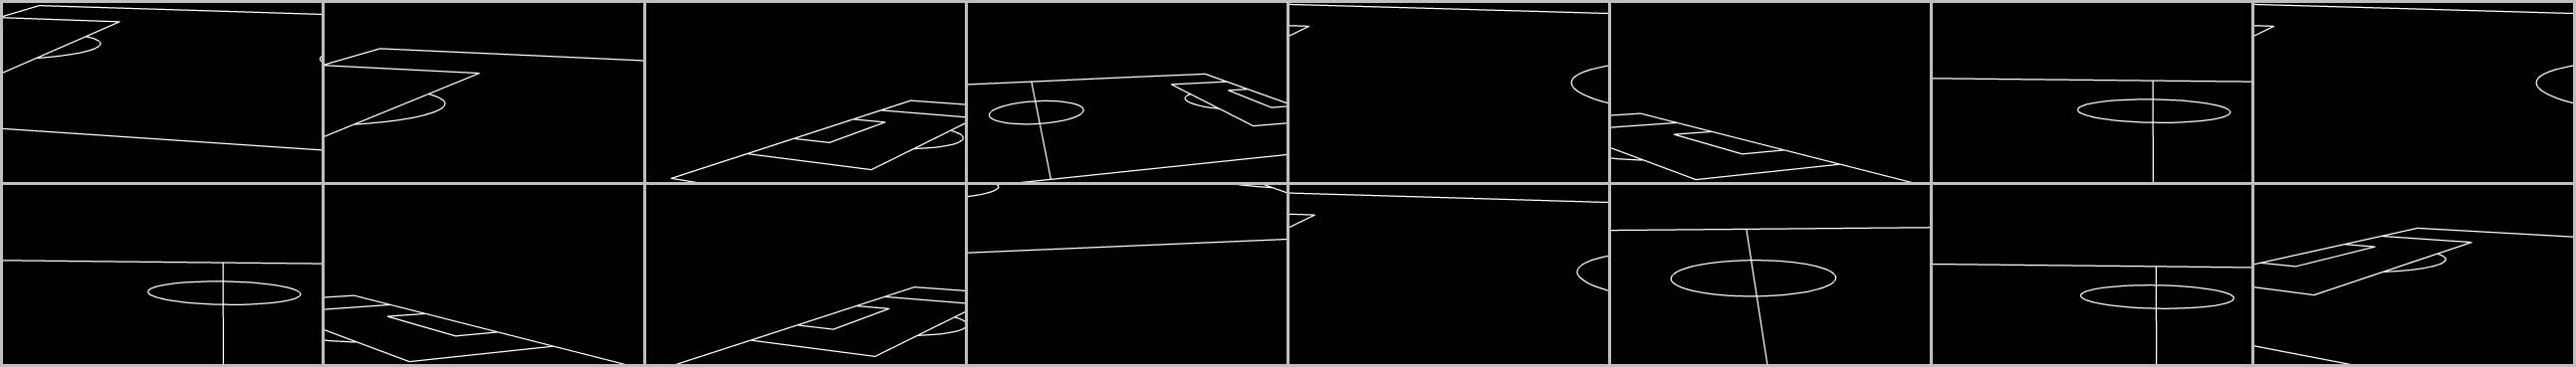

(torch.Size([3, 369, 2587]), None)

In [100]:
bx1, bx2, labels = next(test_loader_iter)
bx1, bx2, labels = bx1.to(device), bx2.to(device), labels.to(device)
feat1, feat2 = siamese(bx1, bx2)
dist = F.pairwise_distance(feat1.detach(), feat2.detach(), keepdim=True)
num_each_row = bx1.shape[0]
print(np.hstack((dist.numpy(), labels.numpy())))
grid_image = make_grid(torch.cat((bx1, bx2), dim=0), nrow=num_each_row, padding=3, normalize=True, pad_value=0.75)
grid_pil_image = transforms.ToPILImage()(grid_image)
grid_image.shape, grid_pil_image.convert('L').show()

#### Single Test

In [101]:
test_001_path = f'{TOP_DIR}/datasets/soccer_seg_detection/single/test_001.jpg'
test_001_det_path = f'{TOP_DIR}/datasets/soccer_seg_detection/det_test_001_fake.png'

In [102]:
img_test_001, img_test_001_det = cv2.imread(test_001_path), cv2.imread(test_001_det_path)
img_test_001.shape, img_test_001_det.shape

((300, 300, 3), (256, 256, 3))

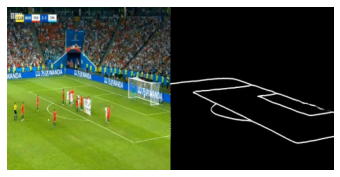

In [103]:
_imshow(np.hstack([cv2.resize(img_test_001, img_test_001_det.shape[:2]), img_test_001_det]))

In [104]:
def extract_siamese_feature(x, net, transform):
    net.eval()
    if len(x.shape) == 3:
        x = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
    x = torch.unsqueeze(transform(Image.fromarray(x)), 0)
    with torch.no_grad():
        x = net._forward_once(x)
        x = x.cpu().numpy().squeeze()
    return x
test_001_feature = extract_siamese_feature(img_test_001_det, siamese, data_transform)
test_001_feature

array([ 0.179223,  0.232438, -0.102645,  0.096902,  0.180415, -0.013689,
       -0.012681, -0.275695,  0.058551,  0.33033 , -0.217882,  0.189507,
       -0.448306, -0.502221,  0.356021, -0.095566], dtype=float32)

### Features Database

#### Generator Features

In [105]:
class FieldEdgeImages(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.size = len(data)
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((180, 320)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.0188], std=[0.128])
            ])
        else:
            self.transform = transform

    def __len__(self):
        return self.size

    def __getitem__(self, index):
        return self.transform(Image.fromarray(self.data[index]))
        

def generate_features_database(camera_parameter_file, soccer_field_template_file, image_size=(320, 180), image_num=10000):
    camera_param = sio.loadmat(camera_parameter_file)
    motion_param = CameraMotionParameter(
        cc = Stats(camera_param['cc_mean'][0], camera_param['cc_std'][0], camera_param['cc_min'][0], camera_param['cc_max'][0]),
        fl = Stats(camera_param['fl_mean'][0], camera_param['fl_std'][0], camera_param['fl_min'][0], camera_param['fl_max'][0]),
        pan = Stats(min=-35.0, max=35.0),
        roll = Stats(0, 0.2, -1.0, 1.0),
        tilt = Stats(min=-15.0, max=-5.0)
    )
    
    ground_templ = sio.loadmat(soccer_field_template_file)
    soccer_field = SoccerField(ground_templ['points'], ground_templ['line_segment_index'])
    cameras = SyntheticDataset.generate_ptz_cameras(motion_param, image_size=(1280, 720), camera_num=image_num)
    
    image_list = []
    for i in range(image_num):
        image = SyntheticDataset.generate_camera_image(cameras[i], soccer_field, (1280, 720), thickness=4)
        image = cv2.cvtColor(cv2.resize(image, image_size, interpolation=interpolation), cv2.COLOR_BGR2GRAY)
        image_list.append(image)
        
    return {'images': np.asarray(image_list), 'cameras': cameras}

In [121]:
num = 10000
feature_database_path = f'{TOP_DIR}/data/features_database_{num}.mat'
if os.path.exists(feature_database_path):
    data  = sio.loadmat(feature_database_path)
else:
    data = generate_features_database(camera_parameter_file, soccer_field_template_file, image_num=num)
    dataset = FieldEdgeImages(data['images'], data_transform)
    data_loader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=1)

    ckpts = torch.load(model_save_path, map_location='cpu')
    siamese = SiameseNetwork()
    siamese.load_state_dict(ckpts['model'])
    siamese.eval()

    features = []
    with torch.no_grad():
        for x in data_loader:
            f = siamese._forward_once(x)
            features.append(f.cpu().numpy())
    data['features'] = np.vstack(features)
    sio.savemat(f'{TOP_DIR}/data/features_database_{num}.mat', data)
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'images', 'cameras', 'features'])

#### Find ANN by Flann

In [122]:
TestImage16 = namedtuple('TestImage16', ['raw', 'edge', 'seg', 'det'])
imgs_list = [cv2.imread(f'{TOP_DIR}/data/UoT_soccer/{x}') for x in ('16.jpg', '16_edge_image.jpg', '016_AB_phase1.jpg',  '016_AB_phase2.jpg')]
test16 = TestImage16(imgs_list[0], imgs_list[1], imgs_list[2], imgs_list[3])

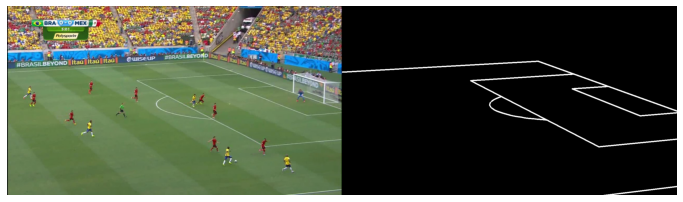

In [108]:
_imshow(np.hstack((test16.raw, test16.edge)), figsize=(12, 4))

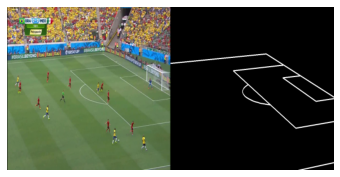

In [109]:
_imshow(np.hstack((cv2.resize(test16.raw, (300, 300), interpolation=interpolation), cv2.resize(test16.edge, (300, 300), interpolation=interpolation))))

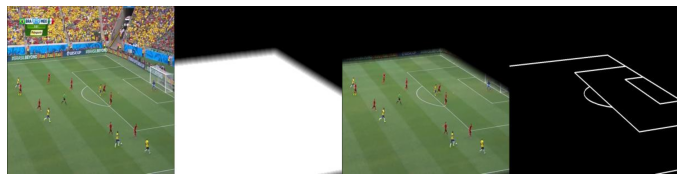

In [110]:
_imshow(np.hstack((test16.seg, test16.det)), figsize=(12, 4))

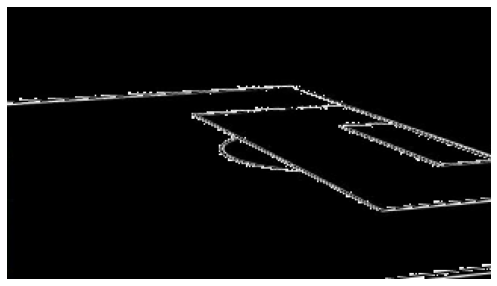

In [111]:
test16_det_edge = test16.det[:, 300:, :]
edge1 = cv2.resize(test16.edge, (320, 180), interpolation=interpolation)
edge2 = cv2.resize(test16_det_edge, (320, 180), interpolation=interpolation)
_imshow(np.abs(edge2 - edge1), figsize=(12, 5))

In [112]:
f1 = extract_siamese_feature(edge1, siamese, data_transform)
f2 = extract_siamese_feature(edge2, siamese, data_transform)
[f'{x:10.5} {y:10.5}' for x, y in zip(f1, f2)]

['   0.24071    0.24211',
 '   0.37697    0.36779',
 '  -0.17575   -0.17104',
 '  -0.15501   -0.15232',
 '   0.36806    0.36829',
 '  -0.20584    -0.2111',
 '   0.36288    0.36322',
 '   0.15544    0.15791',
 '    0.2243     0.2268',
 '   0.27157    0.27229',
 '  -0.36197   -0.36174',
 '  -0.22624   -0.23064',
 ' -0.093667  -0.091738',
 '  0.020108   0.023727',
 '   0.24172    0.24191',
 '  -0.19361   -0.19864']

In [113]:
pyflann.set_distance_type(distance_type='euclidean')
flann = pyflann.FLANN()
params = flann.build_index(data['features'], algorithm='kdtree', trees=8, checks=64)
params.keys(), params['iterations']

(dict_keys(['algorithm', 'checks', 'cb_index', 'eps', 'trees', 'leaf_max_size', 'branching', 'iterations', 'centers_init', 'target_precision', 'build_weight', 'memory_weight', 'sample_fraction', 'log_level', 'random_seed', 'speedup']),
 5)

In [114]:
nbrs1, dists1 = flann.nn_index(f1, 5, checks=params['checks'])
nbrs1, dists1

(array([[2606, 1035, 3899, 6022, 4848]], dtype=int32),
 array([[0.000471, 0.000476, 0.000538, 0.001316, 0.001478]], dtype=float32))

In [115]:
nbrs2, dists2 = flann.nn_index(f2, 5, checks=params['checks'])
nbrs2, dists2

(array([[3899, 4848, 6462, 1035, 2606]], dtype=int32),
 array([[0.00027 , 0.000797, 0.001072, 0.001239, 0.001249]], dtype=float32))

In [116]:
[f'{a:10.5} {b:10.5}, {c:10.5}, {d:10.5}' for a, b, c, d in zip(f1, f2, data['features'][nbrs1[0][0]], data['features'][nbrs2[0][0]])]

['   0.24071    0.24211,    0.24021,    0.24006',
 '   0.37697    0.36779,    0.38706,    0.36939',
 '  -0.17575   -0.17104,   -0.17996,   -0.17356',
 '  -0.15501   -0.15232,     -0.156,   -0.15653',
 '   0.36806    0.36829,     0.3681,    0.36732',
 '  -0.20584    -0.2111,   -0.19972,   -0.21113',
 '   0.36288    0.36322,     0.3599,    0.36642',
 '   0.15544    0.15791,    0.14848,    0.16365',
 '    0.2243     0.2268,     0.2213,    0.22663',
 '   0.27157    0.27229,    0.27371,    0.26793',
 '  -0.36197   -0.36174,   -0.36257,   -0.36009',
 '  -0.22624   -0.23064,   -0.21858,    -0.2334',
 ' -0.093667  -0.091738,   -0.10107,  -0.084136',
 '  0.020108   0.023727,    0.01028,   0.032933',
 '   0.24172    0.24191,    0.24443,    0.23722',
 '  -0.19361   -0.19864,    -0.1887,   -0.19755']

In [117]:
images_f1_nbrs = data['images'][nbrs1[0]]
images_f2_nbrs = data['images'][nbrs2[0]]
images_bchw_f1_nbrs = np.expand_dims(images_f1_nbrs, axis=1)
images_bchw_f2_nbrs = np.expand_dims(images_f2_nbrs, axis=1)
images_bchw_f1_nbrs.shape, images_bchw_f2_nbrs.shape

((5, 1, 180, 320), (5, 1, 180, 320))

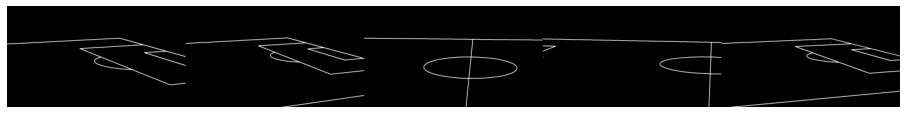

In [118]:
_imshow(np.hstack(images_f1_nbrs), figsize=(16, 4))

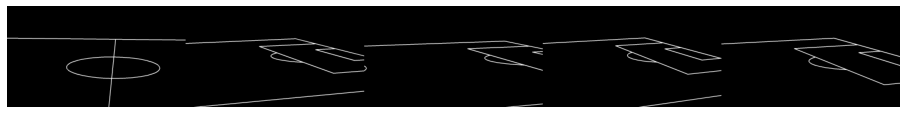

In [119]:
_imshow(np.hstack(images_f2_nbrs), figsize=(16, 4))

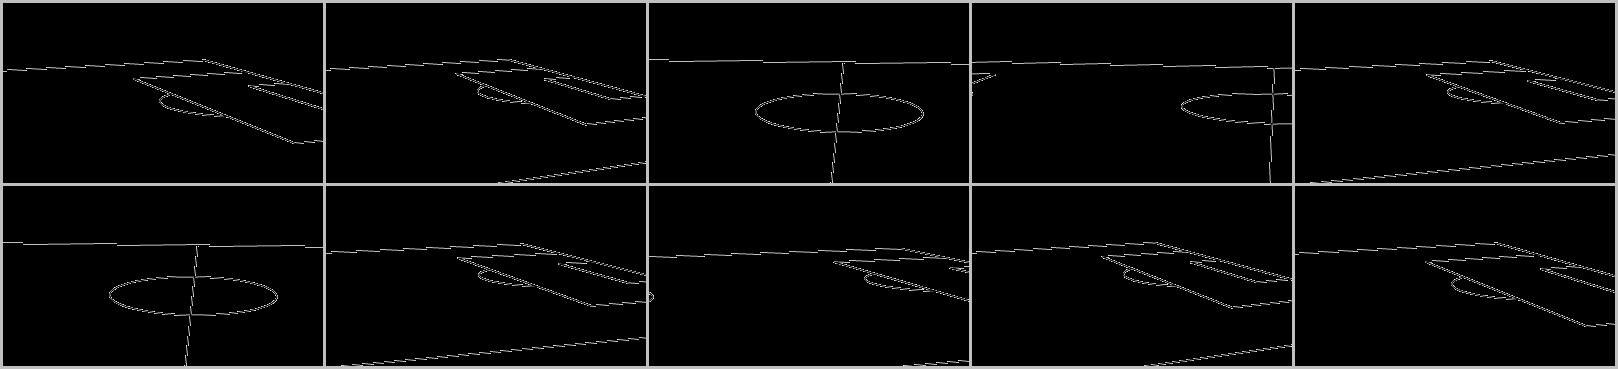

In [120]:
tensor_f1_nbrs = torch.Tensor(images_bchw_f1_nbrs)
tensor_f2_nbrs = torch.Tensor(images_bchw_f2_nbrs)
grid_image = make_grid(torch.cat((tensor_f1_nbrs, tensor_f2_nbrs), dim=0), nrow=images_f1_nbrs.shape[0], padding=3, normalize=False, pad_value=0.75)
grid_pil_image = transforms.ToPILImage()(grid_image)
grid_pil_image

## Refine Camera Parameters

In [ ]:
retrieved_camera_data16 = data['cameras'][nbrs1[0][0]]
retrieved_camera_data16

In [123]:
camera_data16 = np.asarray([640, 360, 3081.976880,
                          1.746393, -0.321347, 0.266827,
                          52.816224, -54.753716, 19.960425])

u, v, fl = camera_data[0:3]
rod_rot = camera_data[3:6]
cc = camera_data[6:9]

camera = ProjectiveCamera(fl, u, v, cc, rod_rot)

# h = IouUtil.template_to_image_homography_uot(camera)
camera.get_homography(), camera.P, camera.rotation

(array([[  2347.075003,    190.868441, 136288.608271],
        [    -0.975424,     -5.057895,  87206.877336],
        [     0.186955,      0.969424,      3.312606]]),
 array([[  2347.075003,    190.868441,   -101.728419, 136288.608271],
        [    -0.975424,     -5.057895,  -2296.848704,  87206.877336],
        [     0.186955,      0.969424,     -0.158951,      3.312606]]),
 array([ 1.724604, -0.164778,  0.140371]))

In [124]:
prop = CameraProp(cx=camera_data16[0], cy=camera_data16[1], fl=camera_data16[2])
pose = CameraPose.from_axis_angle(camera_data16[3:6], camera_data16[6:9])

In [125]:
pose.I

R:
[[ 0.933829 -0.068     0.351197]
 [-0.357712 -0.183794  0.915566]
 [ 0.002289 -0.98061  -0.195957]]
T:
[[-60.054641]
 [ -9.445484]
 [-49.901548]]

In [126]:
pose

R:
[[ 0.933829 -0.357712  0.002289]
 [-0.068    -0.183794 -0.98061 ]
 [ 0.351197  0.915566 -0.195957]]
T:
[[ 52.816224]
 [-54.753716]
 [ 19.960425]]

In [127]:
camera_16 = PerspectiveCamera(prop, pose.I)
camera_16.get_homography(), camera_16.P

(array([[   2879.504332,    -837.166126, -217024.004867],
        [  -1101.637396,    -919.468873,  -47075.320276],
        [      0.002289,      -0.98061 ,     -49.901548]]),
 array([[   2879.504332,    -837.166126,     956.968741, -217024.004867],
        [  -1101.637396,    -919.468873,    2751.209467,  -47075.320276],
        [      0.002289,      -0.98061 ,      -0.195957,     -49.901548]]))

In [ ]:
iou = IouUtil.iou_on_template_uot(h, h2)
iou

In [ ]:
h2 = test_UoT['annotation'][:, 15]['homography'][0]

In [ ]:
prop = CameraProp(cx=retrieved_camera_data16[0], cy=retrieved_camera_data16[1], fl=retrieved_camera_data16[2])
pose = CameraPose.from_axis_angle(retrieved_camera_data16[3:6], retrieved_camera_data16[6:9])
camera_16 = PerspectiveCamera(prop, pose)

In [ ]:
pose

In [ ]:
h = camera_16.get_homography()
h

In [ ]:
yard2meter = 0.9144

In [ ]:
m1 = np.asarray([[1, 0, 0],
                 [0, -1, template_h],
                 [0, 0, 1]])
# scale
m2 = np.asarray([[yard2meter, 0, 0],
                 [0, yard2meter, 0],
                 [0, 0, 1]])
tempalte2world = m2 @ m1

In [ ]:
h @ tempalte2world

## Others

In [ ]:
img = cv2.imread(f'{TOP_DIR}/data/16_edge_image.jpg')
show_image(img)

In [ ]:
img = cv2.cvtColor(img, cv.COLOR_BGR2GRAY)
show_image(img)

In [ ]:
_, binary_im = cv2.threshold(img, 10, 255, cv.THRESH_BINARY_INV)
show_image(binary_im)

In [ ]:
dist_im = cv2.distanceTransform(binary_im, cv.DIST_L2, cv.DIST_MASK_PRECISE)
dist_im[dist_im > 255] = 255
dist_im = dist_im.astype(np.uint8)
show_image(dist_im)

In [ ]:
dist_im.max()

In [ ]:
train_sample_data = sio.loadmat('./worldcup_sampled_cameras.mat')

In [ ]:
train_sample_data.keys()

In [ ]:
train_sample_data['pivot_cameras'].shape, train_sample_data['positive_cameras'].shape, train_sample_data['positive_ious'].shape

In [ ]:
for i in range(10000, 10100, 10):
    pivot = train_sample_data['pivot_cameras'][i]
    print(pivot.tolist())

In [ ]:
for i in range(10000, 10100, 10):
    pivot = train_sample_data['positive_cameras'][i]
    print(pivot.tolist())

In [ ]:
train_sample_data['positive_cameras'][0]

In [ ]:
img = ut_camera_to_edge_image()
_imshow(img), img.shape

In [ ]:
def ut_template_to_image_homography_uot():
    camera_data = np.asarray([640, 360, 3081.976880,
                              1.746393, -0.321347, 0.266827,
                              52.816224, -54.753716, 19.960425])

    u, v, fl = camera_data[0:3]
    rod_rot = camera_data[3:6]
    cc = camera_data[6:9]

    camera = ProjectiveCamera(fl, u, v, cc, rod_rot)

    h = IouUtil.template_to_image_homography_uot(camera)
    print('homography is {}'.format(h))

ut_template_to_image_homography_uot()

In [ ]:
def ut_generate_grassland_mask():
    # An example of generate soft mask for grassland segmentation
    import scipy.io as sio

    index = 16 - 1   # image index from 1
    data = sio.loadmat('../../data/UoT_soccer/train_val.mat')
    annotation = data['annotation']
    homo = annotation[0][index][1]  # ground truth homography

    # step 1: generate a 'hard' grass mask
    template_h = 74
    template_w = 115
    tempalte_im = np.ones((template_h, template_w, 1), dtype=np.uint8) * 255

    grass_mask = IouUtil.homography_warp(homo, tempalte_im, (1280, 720), (0));
    cv.imshow('grass mask', grass_mask)
    cv.waitKey(0)

    # step 2: generate a 'soft' grass mask
    dist_threshold = 30  # change this value to change mask boundary
    _, binary_im = cv.threshold(grass_mask, 10, 255, cv.THRESH_BINARY_INV)

    dist_im = cv.distanceTransform(binary_im, cv.DIST_L2, cv.DIST_MASK_PRECISE)

    dist_im[dist_im > dist_threshold] = dist_threshold
    soft_mask = 1.0 - dist_im / dist_threshold  # normalize to [0, 1]

    cv.imshow('soft mask', soft_mask)
    cv.waitKey(0)

    # step 3: soft mask on the original image
    stacked_mask = np.stack((soft_mask,) * 3, axis=-1)
    im = cv.imread('../../data/16.jpg')
    # soft_im = cv.multiply(stacked_mask, im.astype(np.float32)).astype(np.uint8)
    # cv.imshow('soft masked image', soft_im)
    # cv.waitKey(0)


In [ ]:
homo = train_val_UoT['annotation'][0][15][1]
homo

In [ ]:
template_h = 74
template_w = 115
tempalte_im = np.ones((template_h, template_w, 1), dtype=np.uint8) * 255

In [ ]:
grass_mask = IouUtil.homography_warp(homo, tempalte_im, (1280, 720), (0));
show_image(grass_mask)

In [ ]:
dist_threshold = 30
_, binary_im = cv.threshold(grass_mask, 10, 255, cv.THRESH_BINARY_INV)
dist_im = cv.distanceTransform(binary_im, cv.DIST_L2, cv.DIST_MASK_PRECISE)
dist_im[dist_im > dist_threshold] = dist_threshold
show_image(dist_im)

In [ ]:
 soft_mask = 1.0 - dist_im / dist_threshold

In [ ]:
stacked_mask = np.stack((soft_mask,) * 3, axis=-1)
_imshow(stacked_mask)

In [ ]:
im = cv.imread(f'{TOP_DIR}/data/UoT_soccer/16.jpg')
soft_im = cv.multiply(stacked_mask, im.astype(np.float32)).astype(np.uint8)

In [ ]:
_imshow(soft_im)

### wrap

## Referencs

- https://wikiless.org/wiki/Rotation_matrix?lang=en
- https://nhoma.github.io/ "数据集"
- https://github.com/lood339/SCCvSD/
- [Dissecting the Camera Matrix, Part 2: The Extrinsic Matrix][1]
- [Estimating a Homography Matrix][2]

[2]: https://towardsdatascience.com/estimating-a-homography-matrix-522c70ec4b2c
[1]: https://ksimek.github.io/2012/08/22/extrinsic/

In [ ]:
from typing import List
from collections import namedtuple

Stats = namedtuple('Stats', ['mean', 'std', 'min', 'max'], defaults=[None] * 4)

@dataclass
class CameraMotionParameter(object):
    cc: Stats
    fl: Stats
    pan: Stats
    roll: Stats
    tilt: Stats

In [ ]:
CS = CameraMotionParameter(
    cc = Stats(wcp['cc_mean'][0], wcp['cc_std'][0], wcp['cc_min'][0], wcp['cc_max'][0]),
    fl = Stats(wcp['fl_mean'][0], wcp['fl_std'][0], wcp['fl_min'][0], wcp['fl_max'][0]),
    pan = Stats(min=-35.0, max=35.0),
    roll = Stats(0, 0.2, -1.0, 1.0),
    tilt = Stats(min=-15.0, max=-5.0)
)
CS

In [ ]:
len(CS.cc.mean)

In [ ]:
CS.cc.mean

In [ ]:
isinstance(CS.cc.mean, list)

In [ ]:
np.random.normal((0., 1.), (0.1, 0.1), (10, 2))

In [ ]:
isinstance(0.1, float)

In [ ]:
wcp = worldcup_camera_parameter
_print_dictkeys_shape(wcp)

In [ ]:
wcp['cc_mean'].shape